In [1]:
from default import *

PORT = 5011
%cd -q {PROJECT_HOME}

In [2]:
import os
from copy import deepcopy

figure_dir = os.getcwd() + '/022025_experiment/figures'

import numpy as np
import torch
import mlflow
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from copy import deepcopy
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from models.architecture import MLP
from models.processing import StandardScaler
from torch import nn

import pandas as pd

import torch.nn.functional as F

from mlflow.pytorch import load_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

from losses import StiffnessToLoadLoss

import torchmetrics.functional.regression as R
from dataset import FixedPrattTrussDataset

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from tools.mlflow import BasicDataset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

In [3]:
def pratt_stiffness_matrix(H: float, L: float, EA: torch.DoubleTensor):
    H2 = H ** 2
    L2 = L ** 2
    D2_3_2 = (H ** 2 + L ** 2) ** (3 / 2)
    HL = H * L

    EA_L = EA / L
    EA_H = EA / H

    EA_L2_D2_3_2 = EA * L2 / D2_3_2
    EA_HL_D2_3_2 = EA * HL / D2_3_2
    EA_H2_D2_3_2 = EA * H2 / D2_3_2

    k = torch.eye(32).repeat((len(EA), 1, 1))

    k[:, 2, 2] = EA_L[:, 0] + EA_L[:, 1]
    k[:, 2, 4] = -EA_L[:, 1]
    k[:, 3, 3] = EA_H[:, 14]
    k[:, 3, 31] = -EA_H[:, 14]
    k[:, 4, 2] = -EA_L[:, 1]
    k[:, 4, 4] = EA_L[:, 1] + EA_L[:, 2] + EA_L2_D2_3_2[:, 22]
    k[:, 4, 5] = -EA_HL_D2_3_2[:, 22]
    k[:, 4, 6] = -EA_L[:, 2]
    k[:, 4, 30] = -EA_L2_D2_3_2[:, 22]
    k[:, 4, 31] = EA_HL_D2_3_2[:, 22]
    k[:, 5, 4] = -EA_HL_D2_3_2[:, 22]
    k[:, 5, 5] = EA_H[:, 15] + EA_H2_D2_3_2[:, 22]
    k[:, 5, 29] = -EA_H[:, 15]
    k[:, 5, 30] = EA_HL_D2_3_2[:, 22]
    k[:, 5, 31] = -EA_H2_D2_3_2[:, 22]
    k[:, 6, 4] = -EA_L[:, 2]
    k[:, 6, 6] = EA_L[:, 2] + EA_L[:, 3] + EA_L2_D2_3_2[:, 23]
    k[:, 6, 7] = -EA_HL_D2_3_2[:, 23]
    k[:, 6, 8] = -EA_L[:, 3]
    k[:, 6, 28] = -EA_L2_D2_3_2[:, 23]
    k[:, 6, 29] = EA_HL_D2_3_2[:, 23]
    k[:, 7, 6] = -EA_HL_D2_3_2[:, 23]
    k[:, 7, 7] = EA_H[:, 16] + EA_H2_D2_3_2[:, 23]
    k[:, 7, 27] = -EA_H[:, 16]
    k[:, 7, 28] = EA_HL_D2_3_2[:, 23]
    k[:, 7, 29] = -EA_H2_D2_3_2[:, 23]
    k[:, 8, 6] = -EA_L[:, 3]
    k[:, 8, 8] = EA_L[:, 3] + EA_L[:, 4] + EA_L2_D2_3_2[:, 24] + EA_L2_D2_3_2[:, 25]
    k[:, 8, 9] = -EA_HL_D2_3_2[:, 24] + EA_HL_D2_3_2[:, 25]
    k[:, 8, 10] = -EA_L[:, 4]
    k[:, 8, 22] = -EA_L2_D2_3_2[:, 25]
    k[:, 8, 23] = -EA_HL_D2_3_2[:, 25]
    k[:, 8, 26] = -EA_L2_D2_3_2[:, 24]
    k[:, 8, 27] = EA_HL_D2_3_2[:, 24]
    k[:, 9, 8] = -EA_HL_D2_3_2[:, 24] + EA_HL_D2_3_2[:, 25]
    k[:, 9, 9] = EA_H[:, 17] + EA_H2_D2_3_2[:, 24] + EA_H2_D2_3_2[:, 25]
    k[:, 9, 22] = -EA_HL_D2_3_2[:, 25]
    k[:, 9, 23] = -EA_H2_D2_3_2[:, 25]
    k[:, 9, 25] = -EA_H[:, 17]
    k[:, 9, 26] = EA_HL_D2_3_2[:, 24]
    k[:, 9, 27] = -EA_H2_D2_3_2[:, 24]
    k[:, 10, 8] = -EA_L[:, 4]
    k[:, 10, 10] = EA_L[:, 4] + EA_L[:, 5] + EA_L2_D2_3_2[:, 26]
    k[:, 10, 11] = EA_HL_D2_3_2[:, 26]
    k[:, 10, 12] = -EA_L[:, 5]
    k[:, 10, 20] = -EA_L2_D2_3_2[:, 26]
    k[:, 10, 21] = -EA_HL_D2_3_2[:, 26]
    k[:, 11, 10] = EA_HL_D2_3_2[:, 26]
    k[:, 11, 11] = EA_H[:, 18] + EA_H2_D2_3_2[:, 26]
    k[:, 11, 20] = -EA_HL_D2_3_2[:, 26]
    k[:, 11, 21] = -EA_H2_D2_3_2[:, 26]
    k[:, 11, 23] = -EA_H[:, 18]
    k[:, 12, 10] = -EA_L[:, 5]
    k[:, 12, 12] = EA_L[:, 5] + EA_L[:, 6] + EA_L2_D2_3_2[:, 27]
    k[:, 12, 13] = EA_HL_D2_3_2[:, 27]
    k[:, 12, 14] = -EA_L[:, 6]
    k[:, 12, 18] = -EA_L2_D2_3_2[:, 27]
    k[:, 12, 19] = -EA_HL_D2_3_2[:, 27]
    k[:, 13, 12] = EA_HL_D2_3_2[:, 27]
    k[:, 13, 13] = EA_H[:, 19] + EA_H2_D2_3_2[:, 27]
    k[:, 13, 18] = -EA_HL_D2_3_2[:, 27]
    k[:, 13, 19] = -EA_H2_D2_3_2[:, 27]
    k[:, 13, 21] = -EA_H[:, 19]
    k[:, 14, 12] = -EA_L[:, 6]
    k[:, 14, 14] = EA_L[:, 6] + EA_L[:, 7]
    k[:, 14, 16] = -EA_L[:, 7]
    k[:, 15, 15] = EA_H[:, 20]
    k[:, 15, 19] = -EA_H[:, 20]
    k[:, 16, 14] = -EA_L[:, 7]
    k[:, 16, 16] = EA_L[:, 7] + EA_L2_D2_3_2[:, 28]
    k[:, 16, 18] = -EA_L2_D2_3_2[:, 28]
    k[:, 16, 19] = EA_HL_D2_3_2[:, 28]
    k[:, 18, 12] = -EA_L2_D2_3_2[:, 27]
    k[:, 18, 13] = -EA_HL_D2_3_2[:, 27]
    k[:, 18, 16] = -EA_L2_D2_3_2[:, 28]
    k[:, 18, 18] = EA_L[:, 8] + EA_L2_D2_3_2[:, 27] + EA_L2_D2_3_2[:, 28]
    k[:, 18, 19] = EA_HL_D2_3_2[:, 27] - EA_HL_D2_3_2[:, 28]
    k[:, 18, 20] = -EA_L[:, 8]
    k[:, 19, 12] = -EA_HL_D2_3_2[:, 27]
    k[:, 19, 13] = -EA_H2_D2_3_2[:, 27]
    k[:, 19, 15] = -EA_H[:, 20]
    k[:, 19, 16] = EA_HL_D2_3_2[:, 28]
    k[:, 19, 18] = EA_HL_D2_3_2[:, 27] - EA_HL_D2_3_2[:, 28]
    k[:, 19, 19] = EA_H[:, 20] + EA_H2_D2_3_2[:, 27] + EA_H2_D2_3_2[:, 28]
    k[:, 20, 10] = -EA_L2_D2_3_2[:, 26]
    k[:, 20, 11] = -EA_HL_D2_3_2[:, 26]
    k[:, 20, 18] = -EA_L[:, 8]
    k[:, 20, 20] = EA_L[:, 8] + EA_L[:, 9] + EA_L2_D2_3_2[:, 26]
    k[:, 20, 21] = EA_HL_D2_3_2[:, 26]
    k[:, 20, 22] = -EA_L[:, 9]
    k[:, 21, 10] = -EA_HL_D2_3_2[:, 26]
    k[:, 21, 11] = -EA_H2_D2_3_2[:, 26]
    k[:, 21, 13] = -EA_H[:, 19]
    k[:, 21, 20] = EA_HL_D2_3_2[:, 26]
    k[:, 21, 21] = EA_H[:, 19] + EA_H2_D2_3_2[:, 26]
    k[:, 22, 8] = -EA_L2_D2_3_2[:, 25]
    k[:, 22, 9] = -EA_HL_D2_3_2[:, 25]
    k[:, 22, 20] = -EA_L[:, 9]
    k[:, 22, 22] = EA_L[:, 9] + EA_L[:, 10] + EA_L2_D2_3_2[:, 25]
    k[:, 22, 23] = EA_HL_D2_3_2[:, 25]
    k[:, 22, 24] = -EA_L[:, 10]
    k[:, 23, 8] = -EA_HL_D2_3_2[:, 25]
    k[:, 23, 9] = -EA_H2_D2_3_2[:, 25]
    k[:, 23, 11] = -EA_H[:, 18]
    k[:, 23, 22] = EA_HL_D2_3_2[:, 25]
    k[:, 23, 23] = EA_H[:, 18] + EA_H2_D2_3_2[:, 25]
    k[:, 24, 22] = -EA_L[:, 10]
    k[:, 24, 24] = EA_L[:, 10] + EA_L[:, 11]
    k[:, 24, 26] = -EA_L[:, 11]
    k[:, 25, 9] = -EA_H[:, 17]
    k[:, 25, 25] = EA_H[:, 17]
    k[:, 26, 8] = -EA_L2_D2_3_2[:, 24]
    k[:, 26, 9] = EA_HL_D2_3_2[:, 24]
    k[:, 26, 24] = -EA_L[:, 11]
    k[:, 26, 26] = EA_L[:, 11] + EA_L[:, 12] + EA_L2_D2_3_2[:, 24]
    k[:, 26, 27] = -EA_HL_D2_3_2[:, 24]
    k[:, 26, 28] = -EA_L[:, 12]
    k[:, 27, 7] = -EA_H[:, 16]
    k[:, 27, 8] = EA_HL_D2_3_2[:, 24]
    k[:, 27, 9] = -EA_H2_D2_3_2[:, 24]
    k[:, 27, 26] = -EA_HL_D2_3_2[:, 24]
    k[:, 27, 27] = EA_H[:, 16] + EA_H2_D2_3_2[:, 24]
    k[:, 28, 6] = -EA_L2_D2_3_2[:, 23]
    k[:, 28, 7] = EA_HL_D2_3_2[:, 23]
    k[:, 28, 26] = -EA_L[:, 12]
    k[:, 28, 28] = EA_L[:, 12] + EA_L[:, 13] + EA_L2_D2_3_2[:, 23]
    k[:, 28, 29] = -EA_HL_D2_3_2[:, 23]
    k[:, 28, 30] = -EA_L[:, 13]
    k[:, 29, 5] = -EA_H[:, 15]
    k[:, 29, 6] = EA_HL_D2_3_2[:, 23]
    k[:, 29, 7] = -EA_H2_D2_3_2[:, 23]
    k[:, 29, 28] = -EA_HL_D2_3_2[:, 23]
    k[:, 29, 29] = EA_H[:, 15] + EA_H2_D2_3_2[:, 23]
    k[:, 30, 4] = -EA_L2_D2_3_2[:, 22]
    k[:, 30, 5] = EA_HL_D2_3_2[:, 22]
    k[:, 30, 28] = -EA_L[:, 13]
    k[:, 30, 30] = EA_L[:, 13] + EA_L2_D2_3_2[:, 21] + EA_L2_D2_3_2[:, 22]
    k[:, 30, 31] = EA_HL_D2_3_2[:, 21] - EA_HL_D2_3_2[:, 22]
    k[:, 31, 3] = -EA_H[:, 14]
    k[:, 31, 4] = EA_HL_D2_3_2[:, 22]
    k[:, 31, 5] = -EA_H2_D2_3_2[:, 22]
    k[:, 31, 30] = EA_HL_D2_3_2[:, 21] - EA_HL_D2_3_2[:, 22]
    k[:, 31, 31] = EA_H[:, 14] + EA_H2_D2_3_2[:, 21] + EA_H2_D2_3_2[:, 22]

    return k

# MSE Only

In [14]:
def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion):
    model.train()

    input, target, _, _, _ = batch
    input, target = input.to(device), target.to(device)

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    optimizer.zero_grad()
    loss = criterion(z_target_pred, z_target)
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion):
    model.eval()
    with torch.no_grad():
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        loss = criterion(z_target_pred, z_target)

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch + 1)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer, criterion,
          log_step=10):
    model = model.to(device)
    criterion = criterion.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer, criterion)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler, criterion)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch + 1)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch + 1}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch + 1, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch + 1})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion, fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': f"{lr:.1e}",
            'criterion': criterion.__name__,
        })

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr), criterion(), log_step=log_step)

In [15]:
def plot(results, configs, metric, labels, log=True, xlim=None, ylim=None):
    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, len(configs)))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data but collect the handles for the legend
    config_handles = []
    for i, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])
        h = ax.plot(np.arange(l), results[conf][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
        h2 = ax.plot(np.arange(l), results[conf][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
        config_handles.append(h2)

    # Create custom handles for the line style legend
    line_style_handles = [
        Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
        Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
        Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
    ]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    all_handles = line_style_handles + config_handles
    all_labels = ['Training', 'Validation', ''] + labels

    # Create a single legend with both line styles and configurations
    plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
                  title="Legend")

    ax.set_title(f"Evolution of {metric} during training")
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{metric} [/]")
    ax.set_xlabel("epoch [/]")

    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)

    plt.tight_layout()
    # Adjust right padding to make room for the legend
    plt.show()

## Hyperparameter tuning

### Model capacity

In [6]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("model_capacity")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 10

dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

n_layers_values = [2, 3, 4, 5]
n_neurons_values = [65, 70, 80, 80, 100, 120]
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for n_layers in n_layers_values:
        for n_neurons in n_neurons_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                hidden_dims = [n_neurons for _ in range(n_layers)]
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': hidden_dims,
                                             'output_dim': 29,
                                             'activation': "relu",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None,
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, kfold, log_step, {'loss': 'mse'})
                futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

2025/05/14 03:30:37 INFO mlflow.tracking.fluent: Experiment with name 'model_capacity' does not exist. Creating a new experiment.


🏃 View run smiling-seal-800 at: http://127.0.0.1:5000/#/experiments/580542739104971203/runs/ed5ec8228f2940108779869ca5124ede
🏃 View run melodic-kit-381 at: http://127.0.0.1:5000/#/experiments/580542739104971203/runs/560fc2b814b546caa67a7d1327f5c4a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/580542739104971203
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/580542739104971203
🏃 View run enthused-boar-571 at: http://127.0.0.1:5000/#/experiments/580542739104971203/runs/2809d12460b44a69a492b09445c12fd9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/580542739104971203
🏃 View run unleashed-skink-194 at: http://127.0.0.1:5000/#/experiments/580542739104971203/runs/5ca8890fa578433ea5b8c1b0d2c30b95
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/580542739104971203
🏃 View run chill-frog-945 at: http://127.0.0.1:5000/#/experiments/580542739104971203/runs/b82656ae946c4b73abbe999b03fb89c9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/58054273

In [7]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("model_capacity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

layers_combinations = set()
for n_layers in runs_df['params.n_hidden_layers'].unique():
    for layer_size in runs_df['params.hidden_layers_size'].unique():
        layers_combinations.add((n_layers, layer_size))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in layers_combinations}
for n, size in layers_combinations:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.n_hidden_layers'] == n) &
        (runs_df['params.hidden_layers_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(n, size)][metric_name].append(
                [metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in list(results.keys()):
    if len(results[k]['val_loss']) == 0:
        del results[k]

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

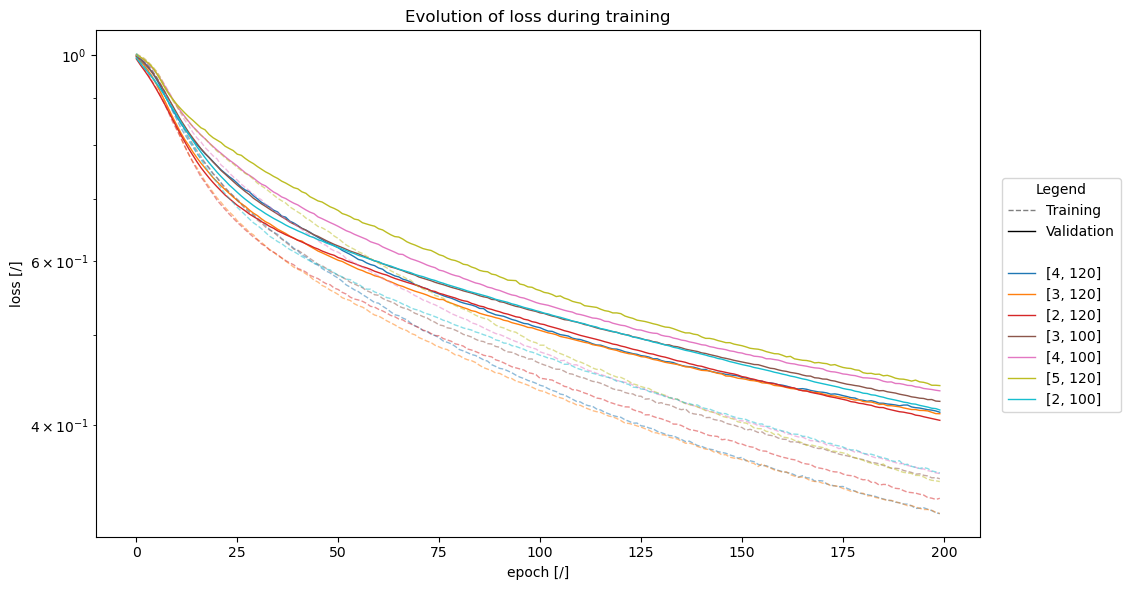

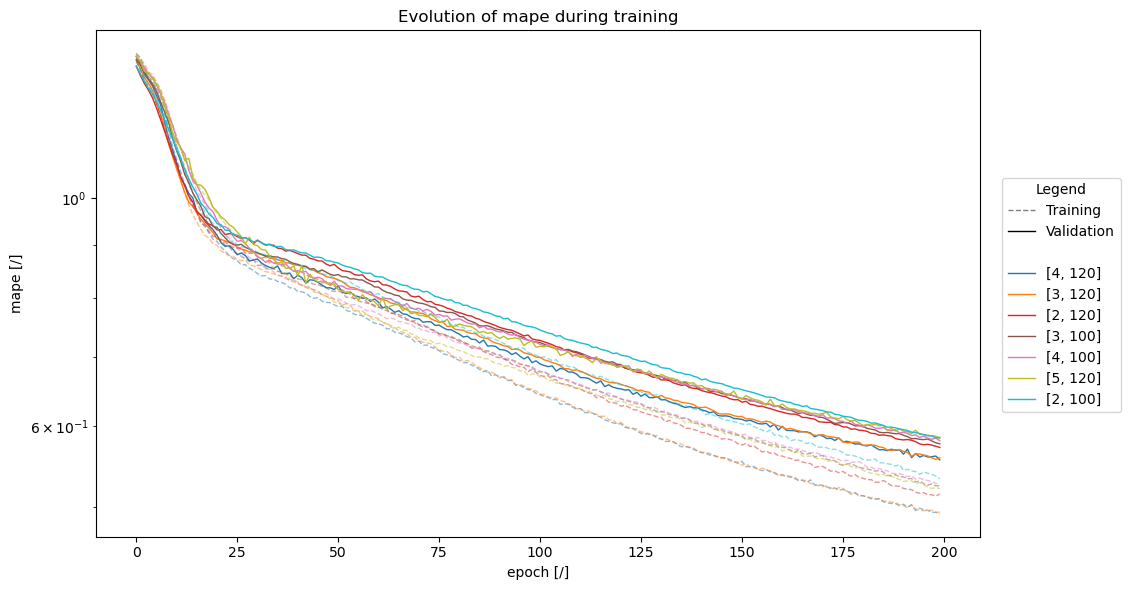

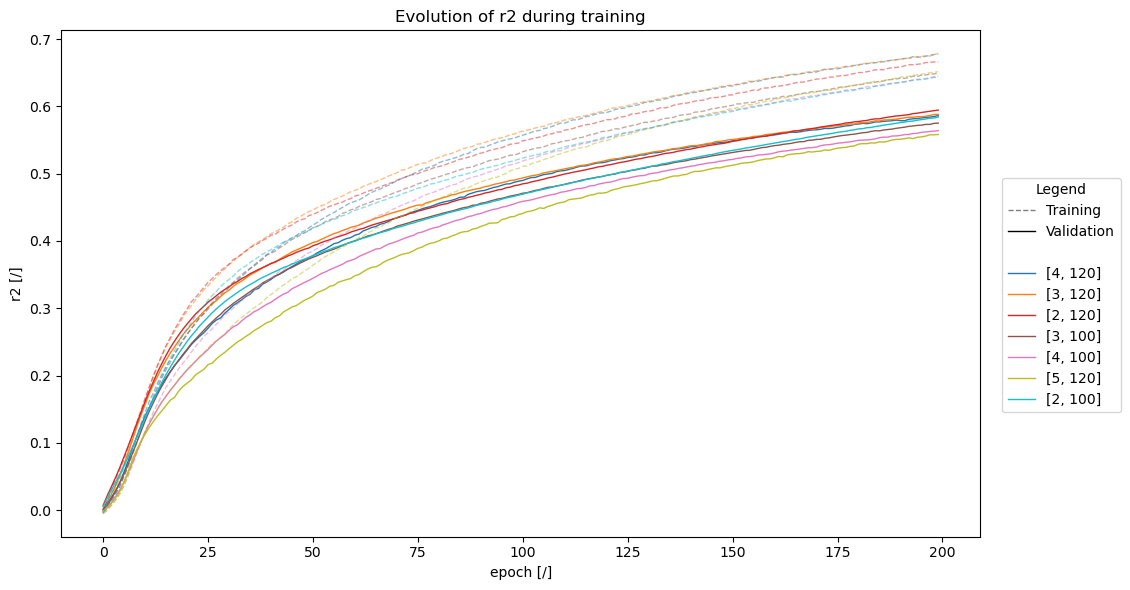

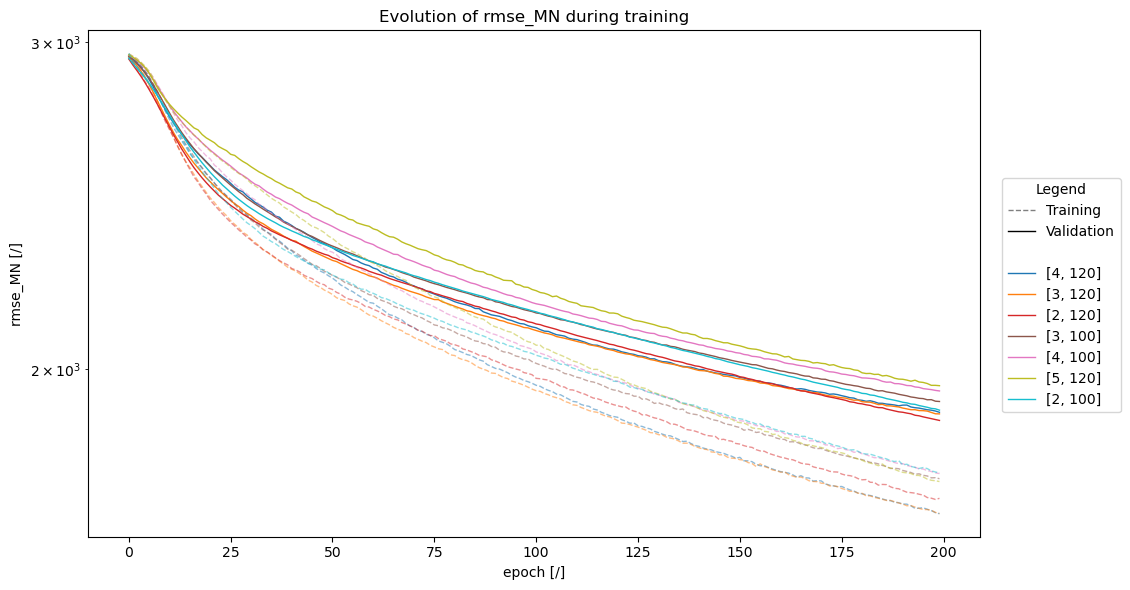

In [8]:
# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs][:7]

labels = [str([int(x) for x in cfg]) for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [9]:
best_hidden_dims = [120 for _ in range(3)]

### Activation function

In [10]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("activation_function")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 100
LR = 5e-4

log_step = -1

kfold = 10
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

activation_values = ['relu', 'gelu', 'tanh', 'sigmoid',
                     'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']
activation_params_values = [None, None, None, None,
                            {'negative_slope': 5e-1}, {'negative_slope': 1e-1}, {'negative_slope': 5e-2},
                            {'negative_slope': 1e-2}]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for activation, activation_params in zip(activation_values, activation_params_values):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 29,
                                         'activation': activation,
                                         'activation_params': activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, kfold, log_step, {'loss': 'mse'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

2025/05/14 07:16:33 INFO mlflow.tracking.fluent: Experiment with name 'activation_function' does not exist. Creating a new experiment.


🏃 View run glamorous-loon-433 at: http://127.0.0.1:5000/#/experiments/427931552705032902/runs/ac0d6934efca448c859c18f48a4357e9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/427931552705032902
🏃 View run grandiose-stag-444 at: http://127.0.0.1:5000/#/experiments/427931552705032902/runs/380744082f674b44a8b65a458bfa0186
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/427931552705032902
🏃 View run nosy-kite-819 at: http://127.0.0.1:5000/#/experiments/427931552705032902/runs/e9d310e79e9d4a4f901a130d3345e85f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/427931552705032902
🏃 View run able-pig-93 at: http://127.0.0.1:5000/#/experiments/427931552705032902/runs/450f501be51a485e9fda9d50141cb187
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/427931552705032902
🏃 View run thundering-foal-345 at: http://127.0.0.1:5000/#/experiments/427931552705032902/runs/961c65238492425d89d5ec45ee4c3b2d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4279315527

In [11]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

activations_combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        activations_combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in activations_combinations}
for k in activations_combinations:
    (act, params) = k
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.activation'] == act) &
        (runs_df['params.activation_params'] == params)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

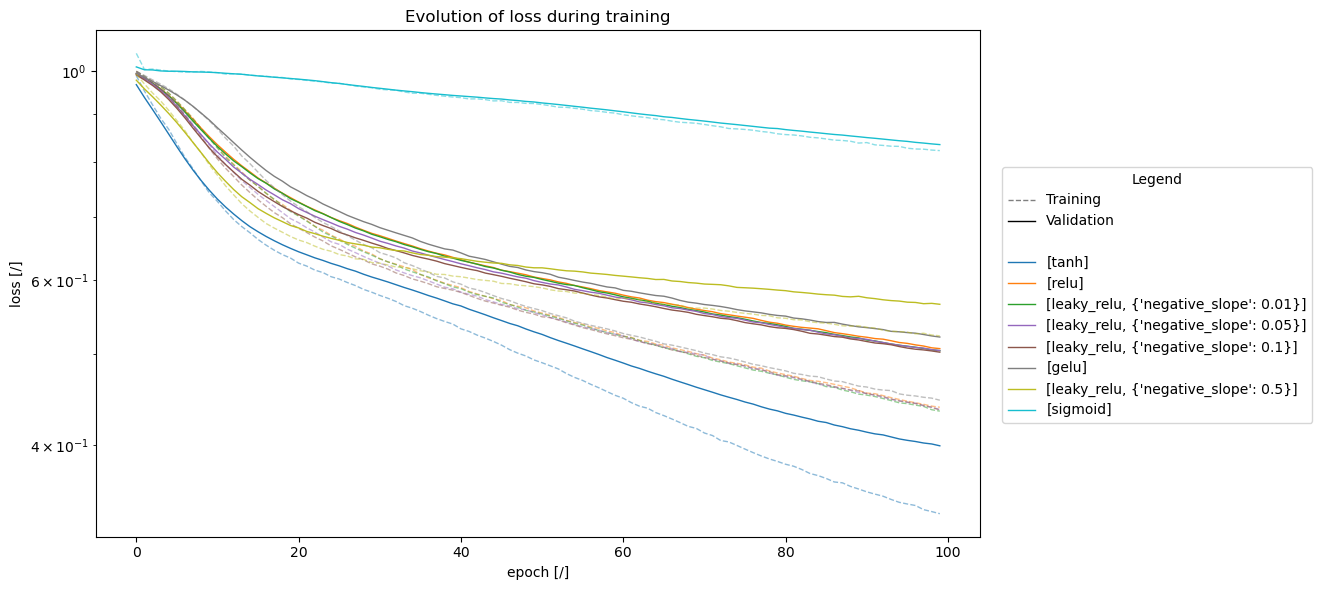

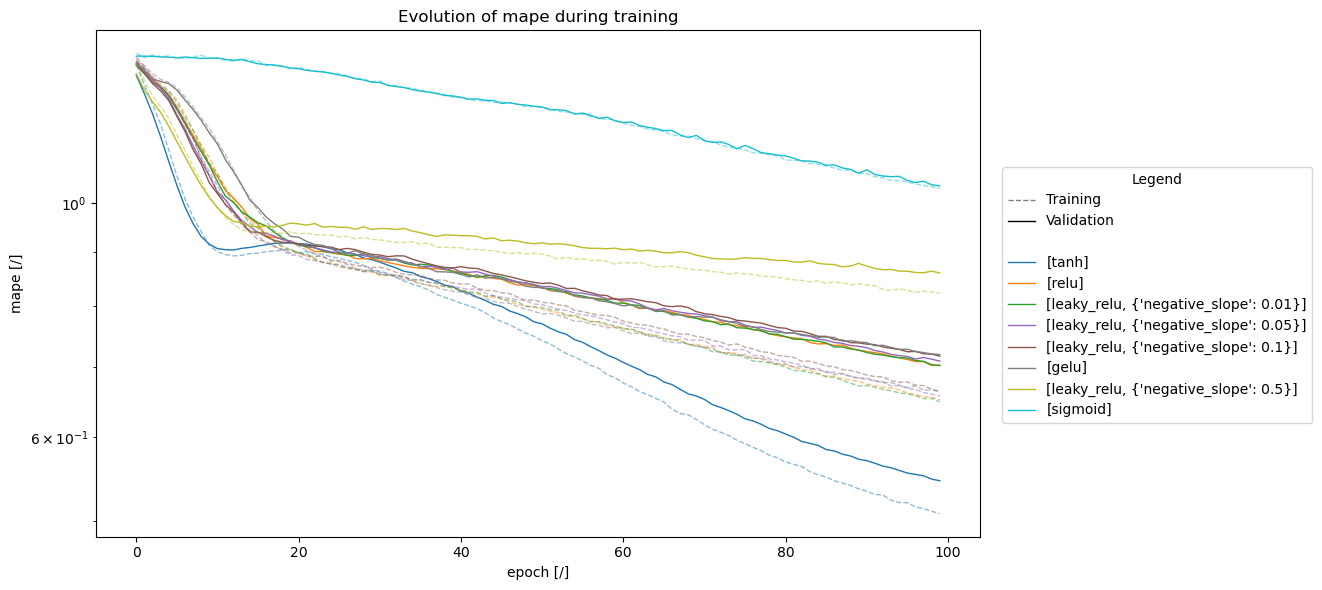

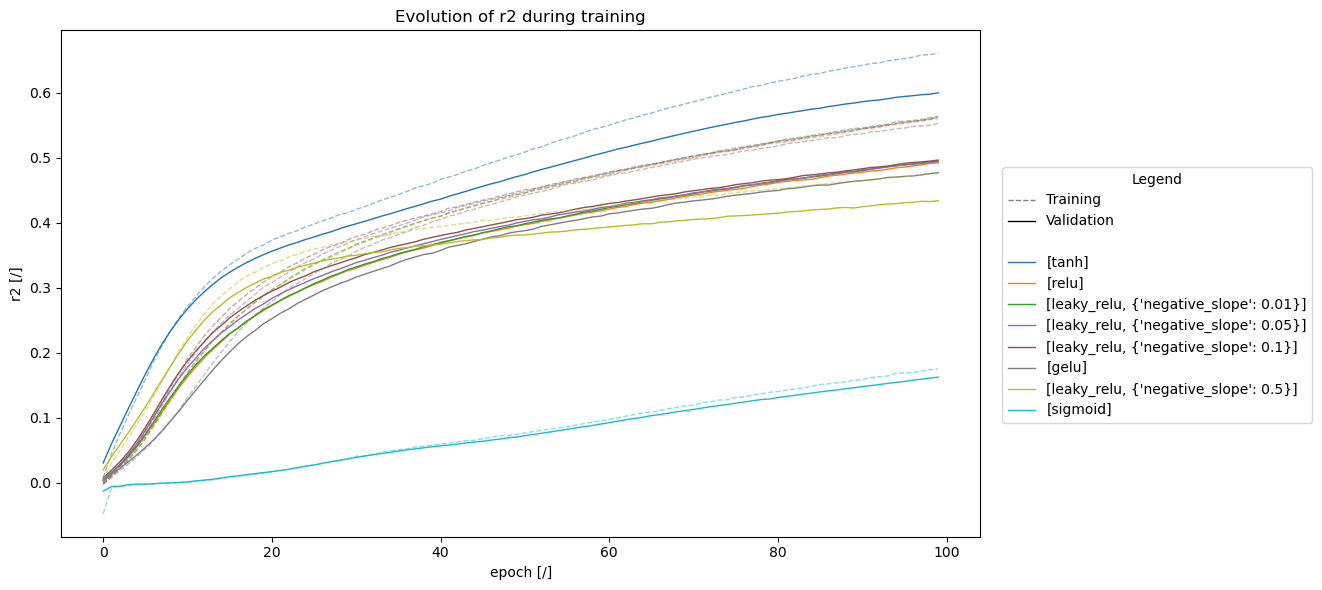

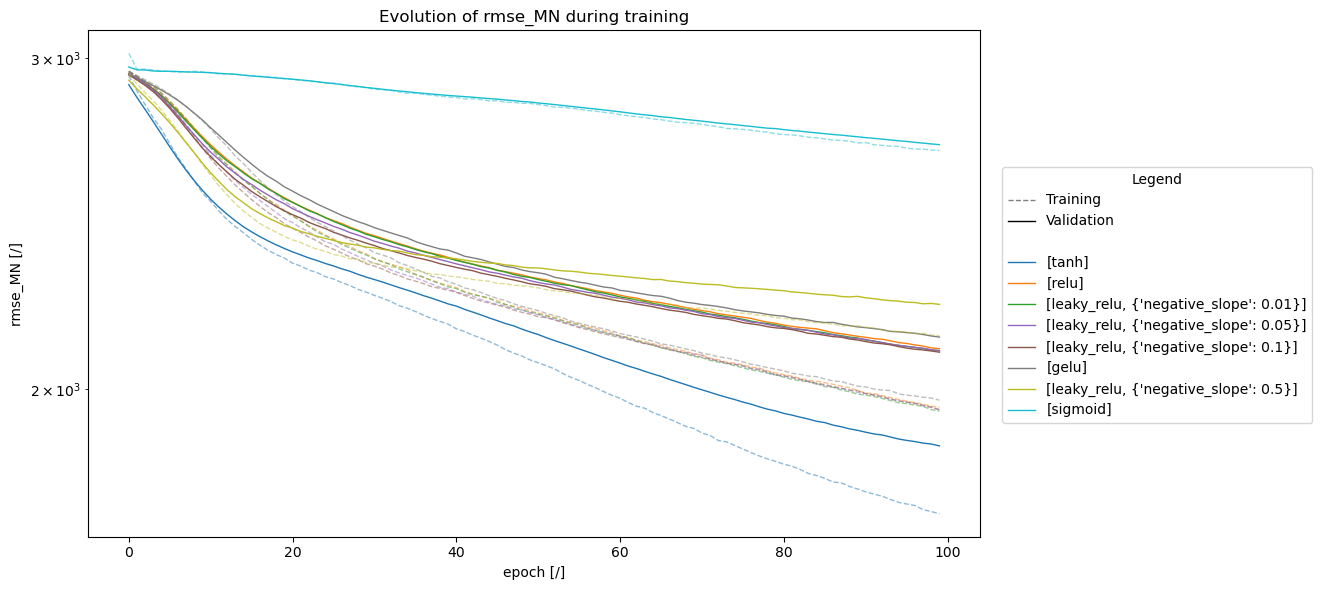

In [12]:
# Your existing code for preparing the data
configs = [x[1] for x in sorted([(np.min(v['val_mape']), k) for k, v in results.items()])]
labels = [f"[{cfg[0]}]" if cfg[1] == 'None' else f"[{cfg[0]}, {cfg[1]}]" for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [13]:
best_activation = 'tanh'
best_activation_params = None

### Learning rate

In [14]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("learning_rate")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 100
lr_values = sorted(np.hstack([f * np.logspace(-4, -3, 2) for f in [1, 2.5, 5, 7.5]]))

log_step = -1

kfold = 10
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for LR in lr_values:
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 29,
                                         'activation': best_activation,
                                         'activation_params': best_activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, kfold, log_step, {'loss': 'mse'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

2025/05/14 07:38:43 INFO mlflow.tracking.fluent: Experiment with name 'learning_rate' does not exist. Creating a new experiment.


🏃 View run fearless-panda-75 at: http://127.0.0.1:5000/#/experiments/598157401778491798/runs/46acb07f452b477ea8bbda4e208f964b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/598157401778491798
🏃 View run beautiful-bass-509 at: http://127.0.0.1:5000/#/experiments/598157401778491798/runs/6f5d2f57d46d4b958d32c13c4e90e117
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/598157401778491798
🏃 View run chill-panda-812 at: http://127.0.0.1:5000/#/experiments/598157401778491798/runs/6db60a1cde9d427d874fbb22aa70c7ca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/598157401778491798
🏃 View run legendary-gnu-120 at: http://127.0.0.1:5000/#/experiments/598157401778491798/runs/fe3fededa8314d44a6b920bc679c5a1f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/598157401778491798
🏃 View run amazing-trout-278 at: http://127.0.0.1:5000/#/experiments/598157401778491798/runs/8d160f7814614025b8d47cd4107e184f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/59815

In [15]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

learning_rates = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in learning_rates}
for lr in learning_rates:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.learning_rate'] == lr)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

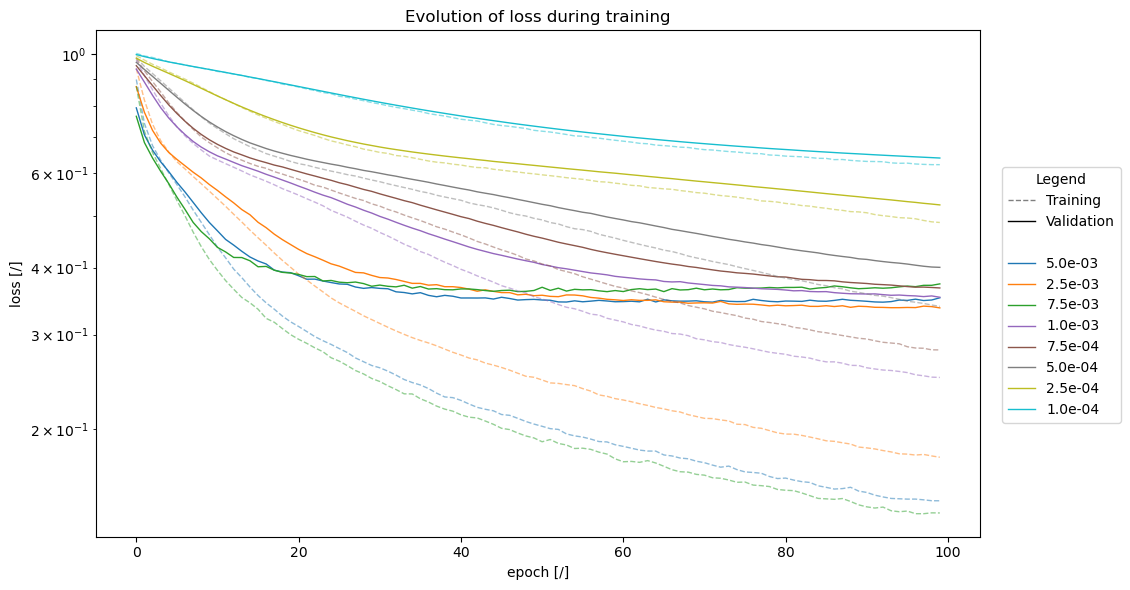

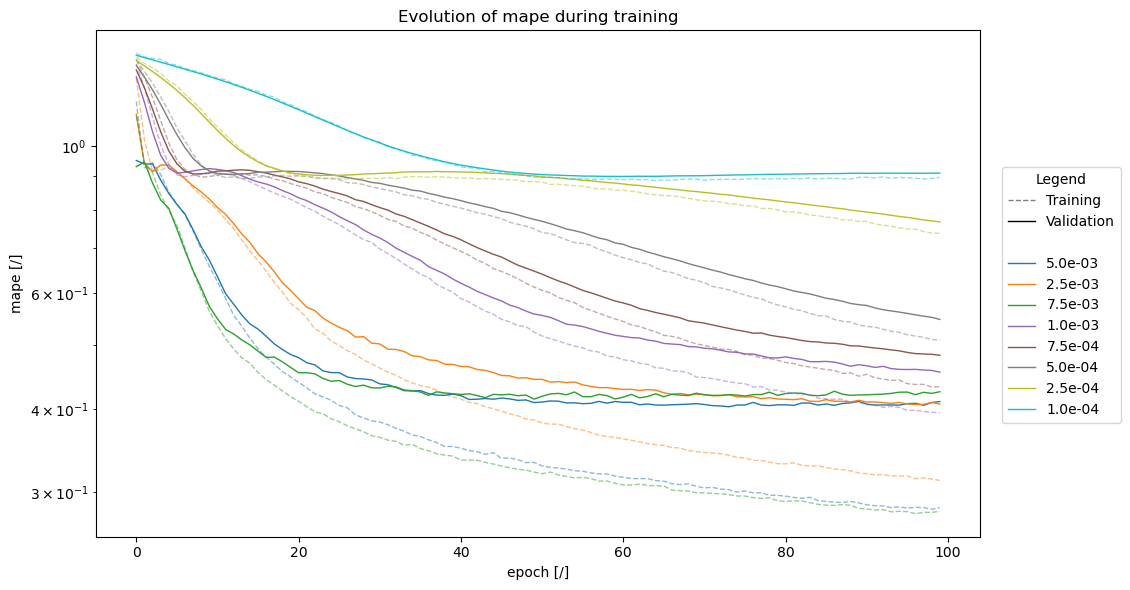

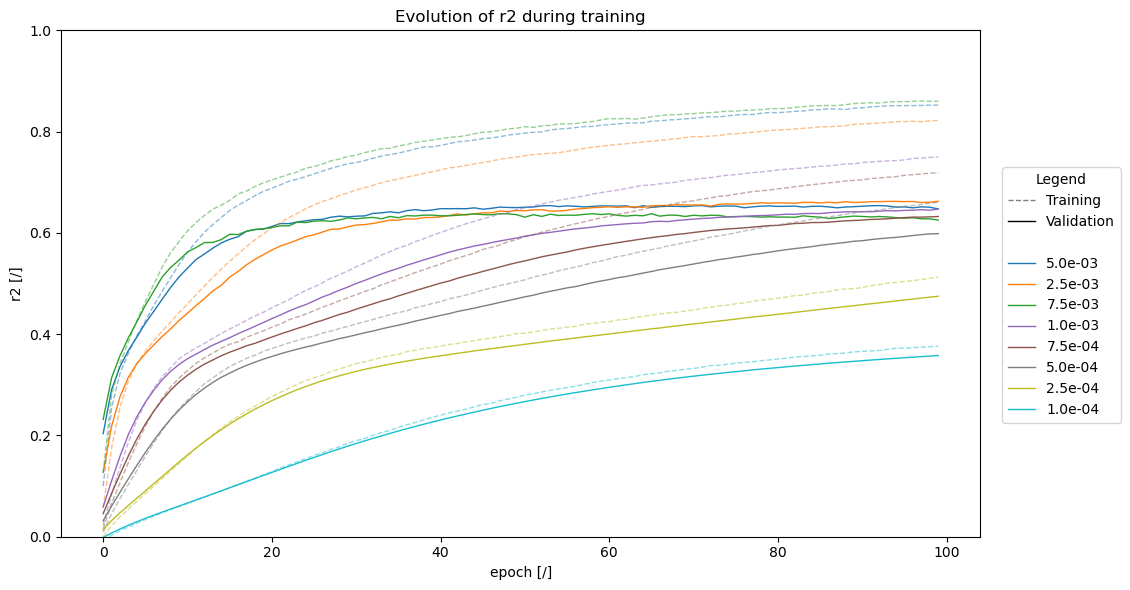

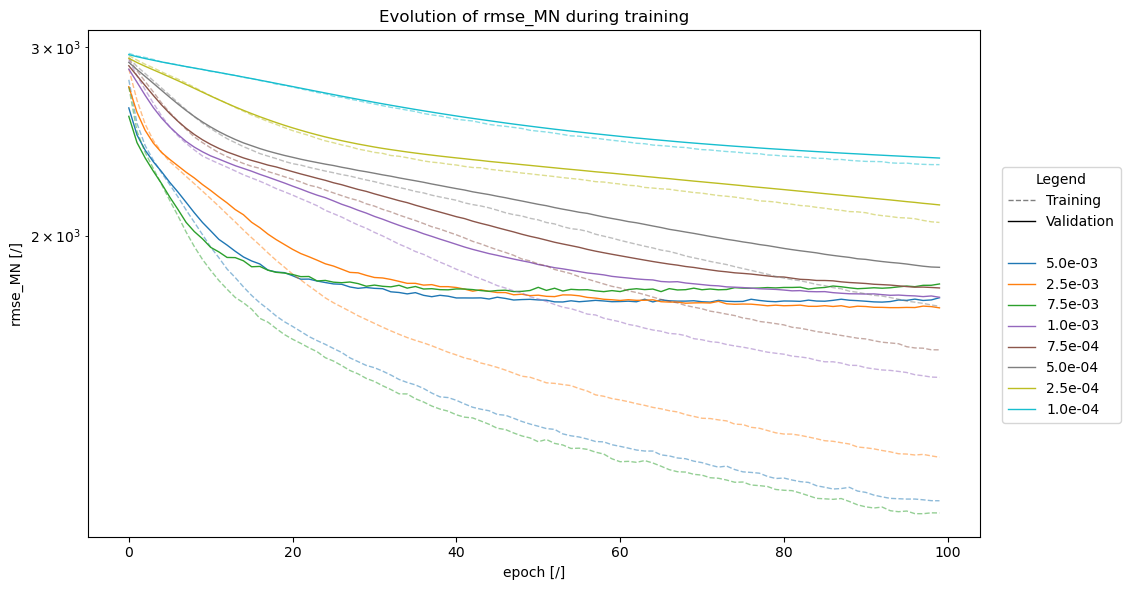

In [16]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{float(c):.1e}" for c in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(0, 1))
plot(results, configs, 'rmse_MN', labels)

In [17]:
best_lr = 1e-3

### Training

In [18]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("training")

VAL_BATCH_SIZE = 8192
N_EPOCH = 1_000
log_step = -1

sizes = [2 ** i for i in range(8, 15)]
batch_size_values = [512 for _ in sizes]  # [int(min(np.power(2, np.floor(np.log2(n)) - 1), 512)) for n in sizes]
dataset_path_values = [f"data/dataset/pratt_truss_bridge/multiple_ea/train_{n}.hdf5" for n in sizes]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
        size = sizes[i]
        train_dataset = FixedPrattTrussDataset(dataset_path)
        vdataset_path_values = [f"data/dataset/pratt_truss_bridge/multiple_ea/train_{n}.hdf5" for n in sizes]
        future = executor.submit(trial_routine, None, train,
                                 {
                                     'input_dim': 65,
                                     'hidden_dims': best_hidden_dims,
                                     'output_dim': 29,
                                     'activation': best_activation,
                                     'activation_params': best_activation_params,
                                     'dropout': 0.0,
                                     'batch_norm': False,
                                     'layer_norm': False,
                                     'normalization_params': None,
                                     'output_activation': None,
                                     'output_activation_params': None
                                 },
                                 train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                 N_EPOCH,
                                 torch.optim.Adam, best_lr, nn.MSELoss,
                                 -1, log_step, {'loss': 'mse', 'noise': 0.})
        futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

2025/05/14 07:57:08 INFO mlflow.tracking.fluent: Experiment with name 'training' does not exist. Creating a new experiment.


🏃 View run beautiful-slug-949 at: http://127.0.0.1:5000/#/experiments/965839871236026849/runs/55fbf980871747499d21d4cf6d489222
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/965839871236026849
🏃 View run debonair-kite-632 at: http://127.0.0.1:5000/#/experiments/965839871236026849/runs/82779e4e98fb457c99587de59f465b63
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/965839871236026849
🏃 View run salty-ape-154 at: http://127.0.0.1:5000/#/experiments/965839871236026849/runs/f67c2c7b630d42e0ba6513e43b651e26
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/965839871236026849
🏃 View run beautiful-hawk-152 at: http://127.0.0.1:5000/#/experiments/965839871236026849/runs/903a8aaab48c4865a7060235d31c8499
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/965839871236026849
🏃 View run auspicious-bat-419 at: http://127.0.0.1:5000/#/experiments/965839871236026849/runs/a050933af11c46b2977ae191aab1e38b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/96583

In [19]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

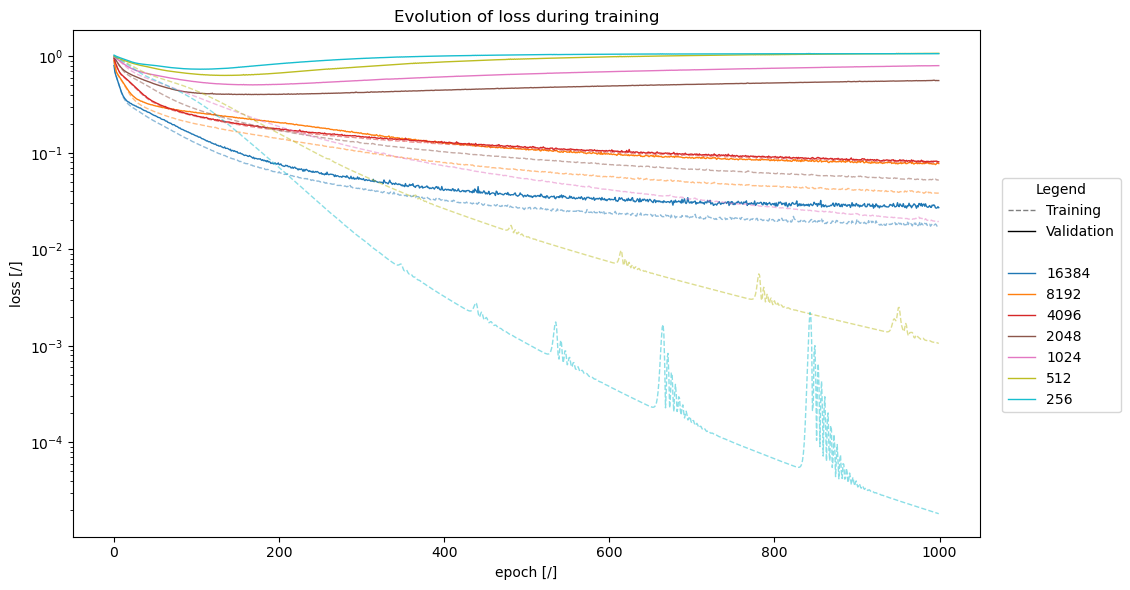

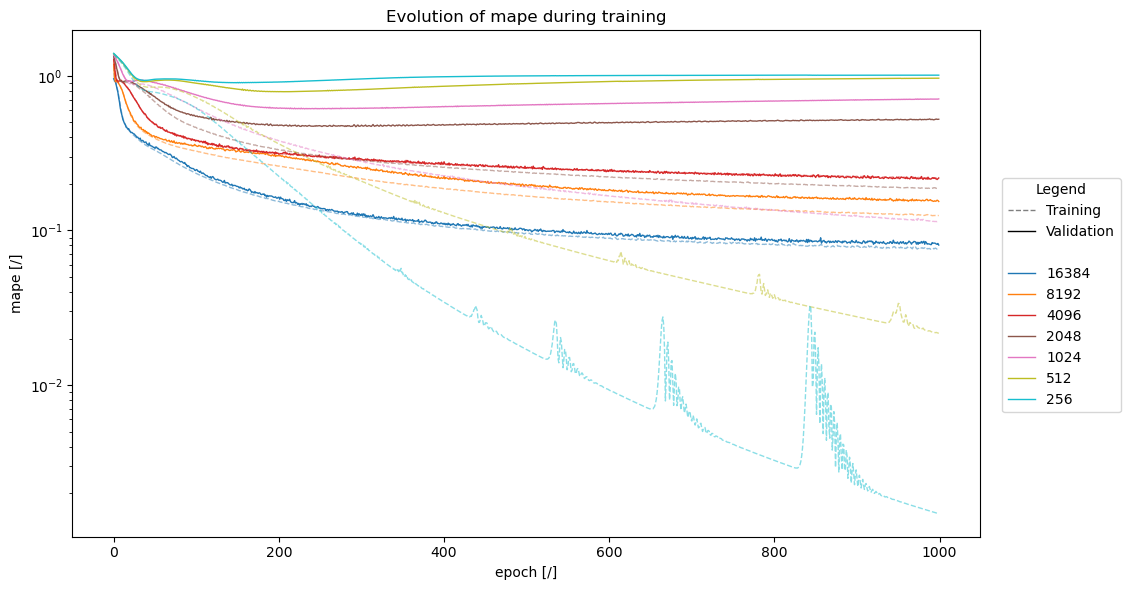

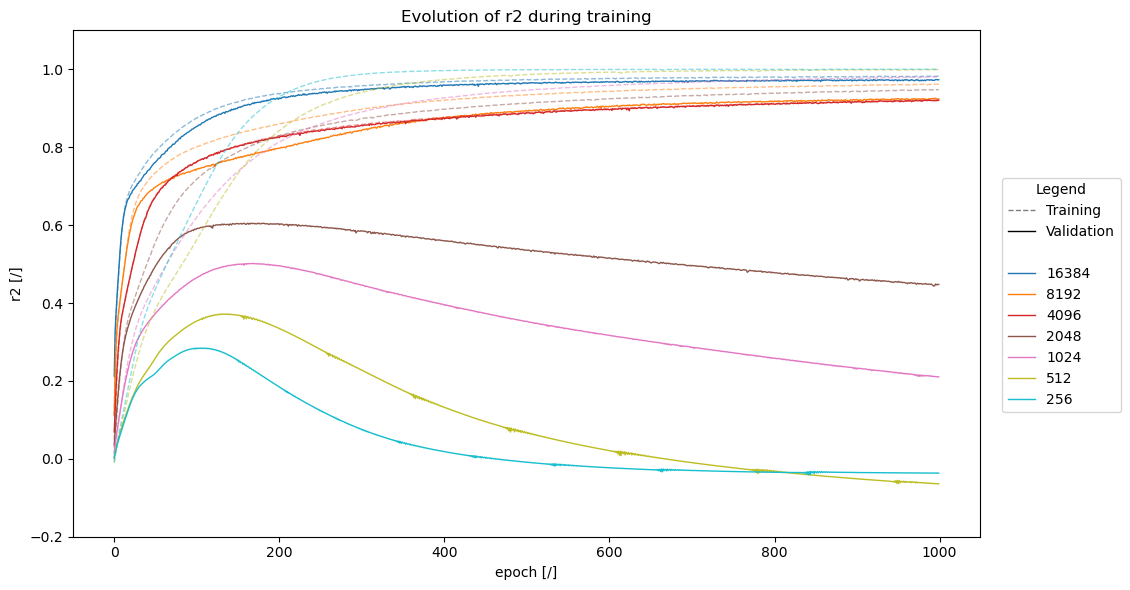

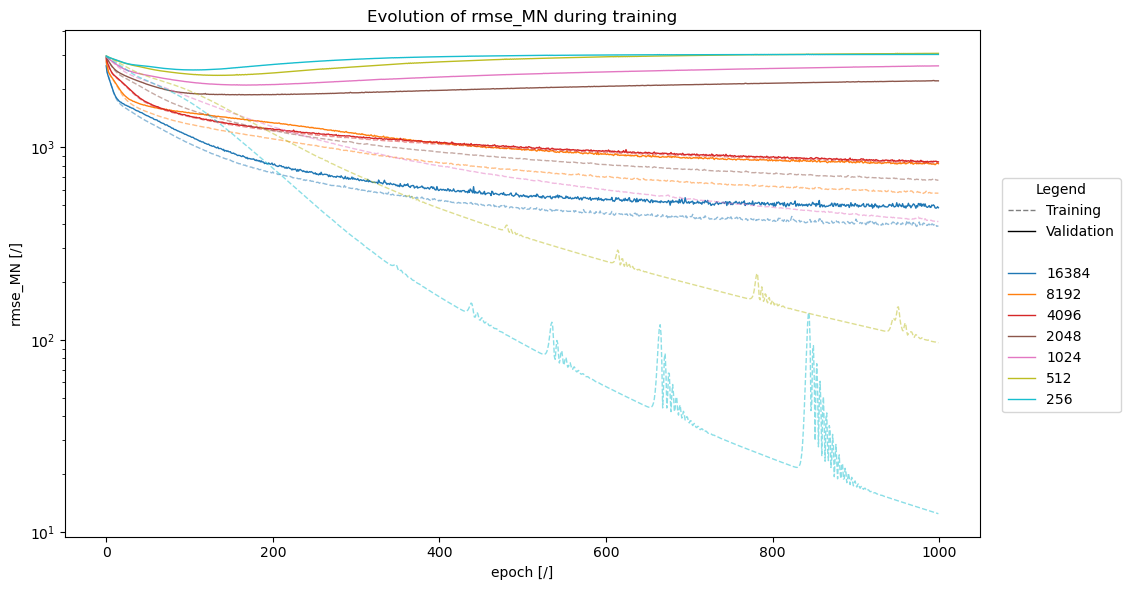

In [20]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{int(size)}" for size in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(-.2, 1.1))
plot(results, configs, 'rmse_MN', labels)

### Noise sensitivity

In [17]:
%%capture
for set_path, set_name in zip(
        ["data/dataset/pratt_truss_bridge/test/single_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/member_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/all_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/mixed_8192.hdf5"],
        ['single_ea', 'member_ea', 'multiple_ea', 'mixed_ea']
):
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    experiment = mlflow.get_experiment_by_name("training")
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[runs_df['params.loss'] == 'mse']

    results = []

    for f in np.linspace(0, .1, 6):
        validation_ds = FixedPrattTrussDataset(
            set_path,
            f_noise_length=None,
            f_noise_loads=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
            f_noise_strain=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
            f_noise_displacement=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
        )

        dl = DataLoader(validation_ds, batch_size=8192)

        for i in range(len(runs_df[['artifact_uri', 'params.train_size']])):
            artifact_uri = runs_df.iloc[i]['artifact_uri']
            size = runs_df.iloc[i]['params.train_size']

            uri = f"{artifact_uri}/input_scaler/"
            input_scaler = load_model(uri)

            uri = f"{artifact_uri}/target_scaler/"
            target_scaler = load_model(uri)

            uri = f"{artifact_uri}/mape_model/"
            model = load_model(uri)

            for batch in dl:
                metrics = validation(model, batch, input_scaler, target_scaler, F.mse_loss)

            results.append((size, f, metrics))

    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("noise_sensitivity")

    df = pd.DataFrame([[results[i][0], results[i][1],
                        results[i][2]['r2'].item(),
                        results[i][2]['mape'].item(),
                        results[i][2]['rmse_MN'].item(),
                        results[i][2]['loss']]
                       for i in range(len(results))],
                      columns=['train_size', 'noise', 'r2', 'mape', 'rmse_MN', 'loss'])
    df.sort_values(by=['train_size', 'noise'], axis=0, ignore_index=True, inplace=True)

    for size in df.train_size.unique():
        with mlflow.start_run():
            df_2 = df[df['train_size'] == size]
            # Model information logging
            mlflow.log_params({
                'train_size': size,
                'loss': 'mse',
                'test_set': set_name
            })
            for i in range(len(df_2)):
                mlflow.log_metrics(
                    dict(df_2.iloc[i][1:]),
                    step=i
                )

# PINN Only

In [18]:
def u_from_x(x, n_panels=8):
    batch_size = len(x)
    u = torch.zeros((batch_size, 4 * n_panels), device=x.device)
    u[:, 2:2 * n_panels + 1] = x[:, :2 * (n_panels - 1) + 1]
    u[:, 2 * (n_panels + 1):] = x[:, 2 * (n_panels - 1) + 1:4 * n_panels - 3]
    return u.unsqueeze(-1)


def q_from_x_q(x, q, n_panels=8):
    q = q.squeeze(-1)
    q[:, np.arange(3, 2 * n_panels, 2)] = x[:, 4 * n_panels - 3: 5 * n_panels - 4]

    return q.unsqueeze(-1)


def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion):
    model.train()

    input, target, _, u, q = batch
    input, target = input.to(device), target.to(device)
    u, q = u.to(device), q.to(device)
    q[:, [0, 1, 17], :] = 0.

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    k_pred = pratt_stiffness_matrix(7.5, 7.5, target_pred).to(device)

    optimizer.zero_grad()
    loss = criterion(k_pred * 1e-6,
                     u_from_x(input, 8) * 1e3,
                     q_from_x_q(input, q, 8) * 1e-3)
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion):
    model.eval()
    with torch.no_grad():
        input, target, _, u, q = batch
        input, target = input.to(device), target.to(device)
        u, q = u.to(device), q.to(device)
        q[:, [0, 1, 17], :] = 0.

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        k_pred = pratt_stiffness_matrix(7.5, 7.5, target_pred).to(device)

        loss = criterion(k_pred * 1e-6,
                         u_from_x(input, 8) * 1e3,
                         q_from_x_q(input, q, 8) * 1e-3)

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer, criterion,
          log_step=10):
    model = model.to(device)
    criterion = criterion.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer, criterion)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler, criterion)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch + 1)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch + 1}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch + 1, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch + 1})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion, fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': f"{lr:.1e}",
            'criterion': criterion.__name__,
        })

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr), criterion(), log_step=log_step)

In [19]:
def plot(results, configs, metric, labels, log=True, xlim=None, ylim=None):
    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, len(configs)))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data but collect the handles for the legend
    config_handles = []
    for i, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])
        h = ax.plot(np.arange(l), results[conf][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
        h2 = ax.plot(np.arange(l), results[conf][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
        config_handles.append(h2)

    # Create custom handles for the line style legend
    line_style_handles = [
        Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
        Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
        Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
    ]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    all_handles = line_style_handles + config_handles
    all_labels = ['Training', 'Validation', ''] + labels

    # Create a single legend with both line styles and configurations
    plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
                  title="Legend")

    ax.set_title(f"Evolution of {metric} during training")
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{metric} [/]")
    ax.set_xlabel("epoch [/]")

    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)

    plt.tight_layout()
    # Adjust right padding to make room for the legend
    plt.show()

## Hyperparameter tuning

### Model capacity

In [9]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("model_capacity")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 10
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

n_layers_values = [2, 3, 4, 5]
n_neurons_values = [65, 70, 80, 80, 100, 120]
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for n_layers in n_layers_values:
        for n_neurons in n_neurons_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                hidden_dims = [n_neurons for _ in range(n_layers)]
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': hidden_dims,
                                             'output_dim': 29,
                                             'activation': "relu",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None,
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, StiffnessToLoadLoss, kfold, log_step, {'loss': 'pinn'})
                futures.append(future)
                break

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run zealous-deer-425 at: http://127.0.0.1:5002/#/experiments/580542739104971203/runs/6e6d993540e84041aa1b1113c0fe334e
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/580542739104971203


In [13]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("model_capacity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

layers_combinations = set()
for n_layers in runs_df['params.n_hidden_layers'].unique():
    for layer_size in runs_df['params.hidden_layers_size'].unique():
        layers_combinations.add((n_layers, layer_size))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in layers_combinations}
for n, size in layers_combinations:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'pinn') &
        (runs_df['params.n_hidden_layers'] == n) &
        (runs_df['params.hidden_layers_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(n, size)][metric_name].append(
                [metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

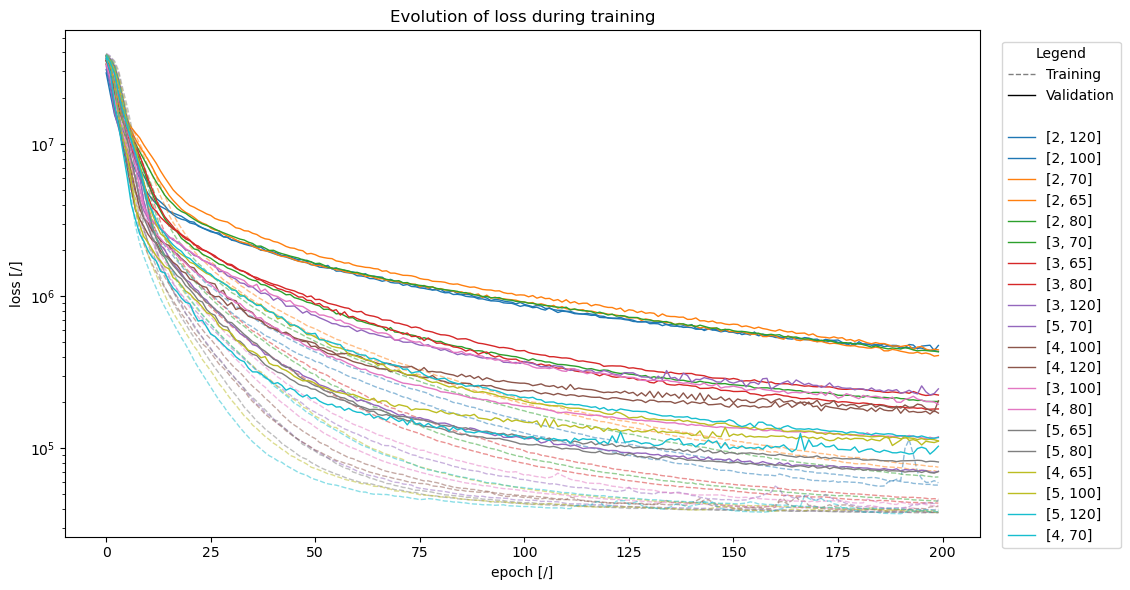

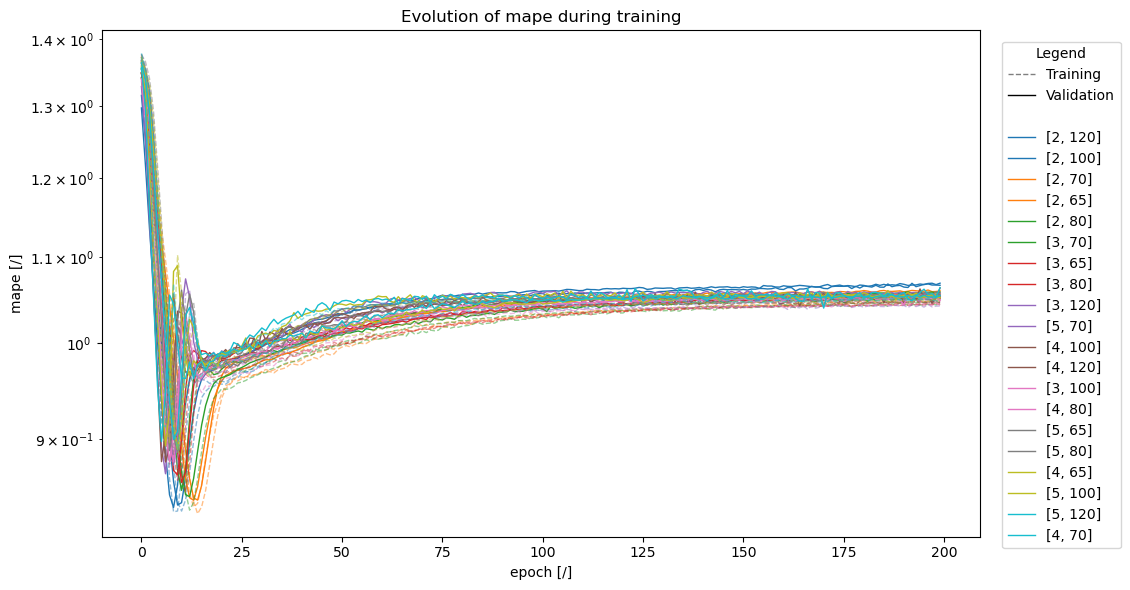

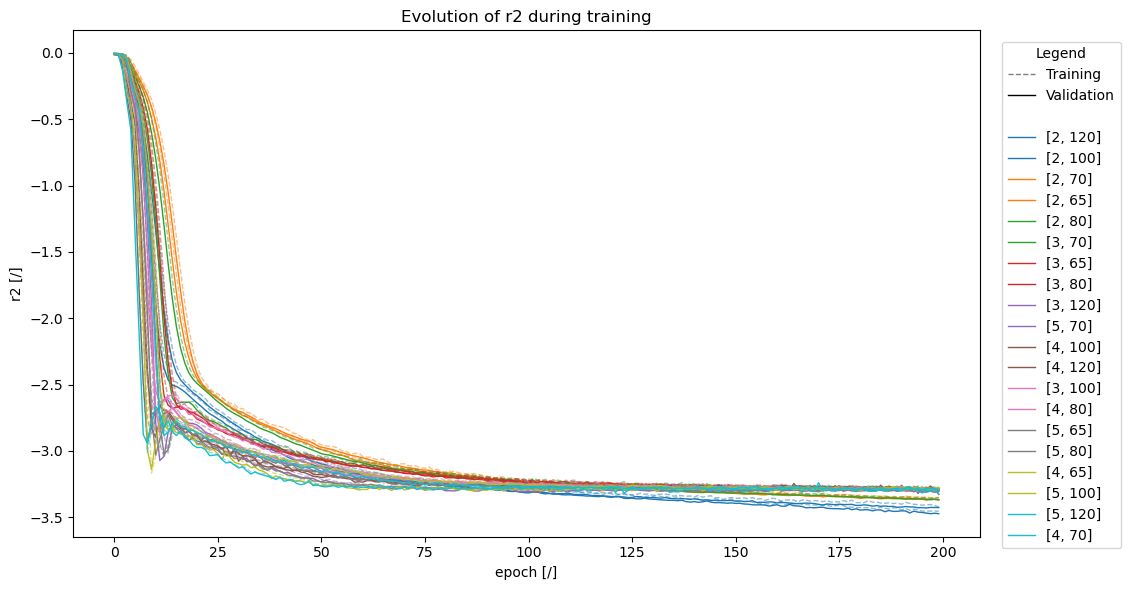

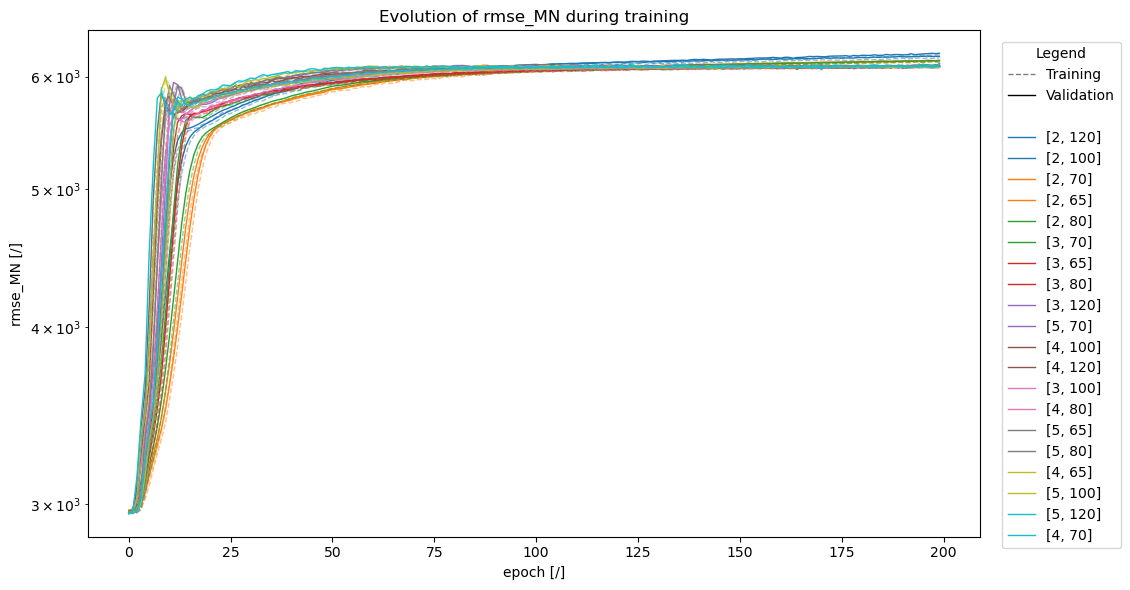

In [14]:
# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs]

labels = [str([int(x) for x in cfg]) for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [36]:
best_hidden_dims = [120 for _ in range(2)]

### Activation function

In [37]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("activation_function")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 100
LR = 5e-4

log_step = -1

kfold = 10
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

activation_values = ['relu', 'gelu', 'tanh', 'sigmoid',
                     'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']
activation_params_values = [None, None, None, None,
                            {'negative_slope': 5e-1}, {'negative_slope': 1e-1}, {'negative_slope': 5e-2},
                            {'negative_slope': 1e-2}]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for activation, activation_params in zip(activation_values, activation_params_values):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 29,
                                         'activation': activation,
                                         'activation_params': activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, StiffnessToLoadLoss, kfold, log_step, {'loss': 'pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run delightful-ox-815 at: http://127.0.0.1:5005/#/experiments/427931552705032902/runs/f3d7f514903b4a459b98b052773a89b0
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/427931552705032902
🏃 View run nervous-ray-818 at: http://127.0.0.1:5005/#/experiments/427931552705032902/runs/9c092b80e0cc4c168c3d2cde9b5afd02
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/427931552705032902
🏃 View run treasured-dove-569 at: http://127.0.0.1:5005/#/experiments/427931552705032902/runs/f2e81759cd24463e81a4cd1e71096578
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/427931552705032902
🏃 View run salty-shark-442 at: http://127.0.0.1:5005/#/experiments/427931552705032902/runs/8c669ae25bd14e18bdb801e0f1b2424e
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/427931552705032902
🏃 View run stately-cow-615 at: http://127.0.0.1:5005/#/experiments/427931552705032902/runs/3c40687f057b4798b082c72ba6a14f5a
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/427931552

In [38]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

activations_combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        activations_combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in activations_combinations}
for k in activations_combinations:
    (act, params) = k
    run_ids = runs_df[
        (runs_df['params.loss'] == 'pinn') &
        (runs_df['params.activation'] == act) &
        (runs_df['params.activation_params'] == params)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

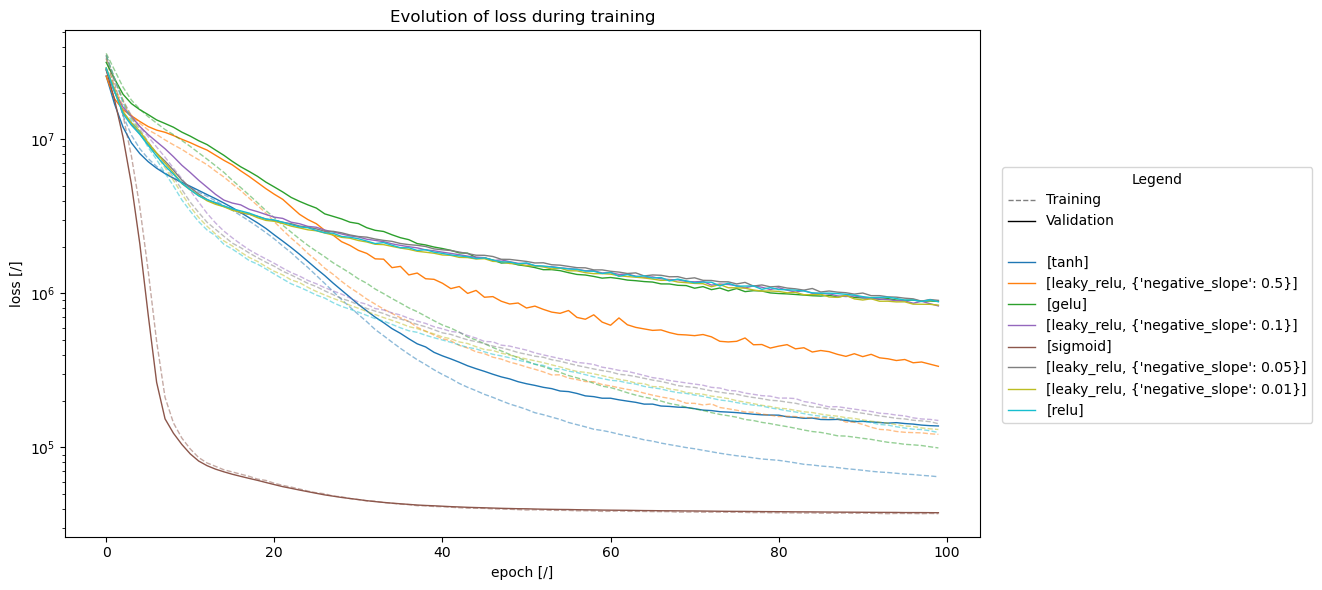

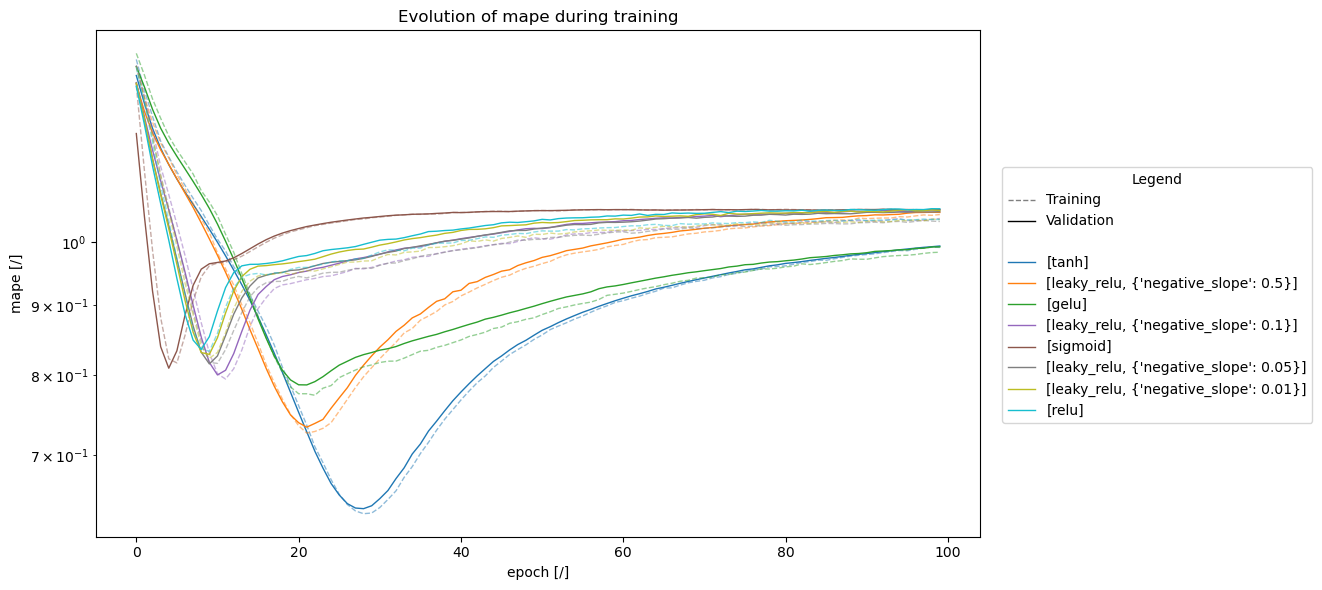

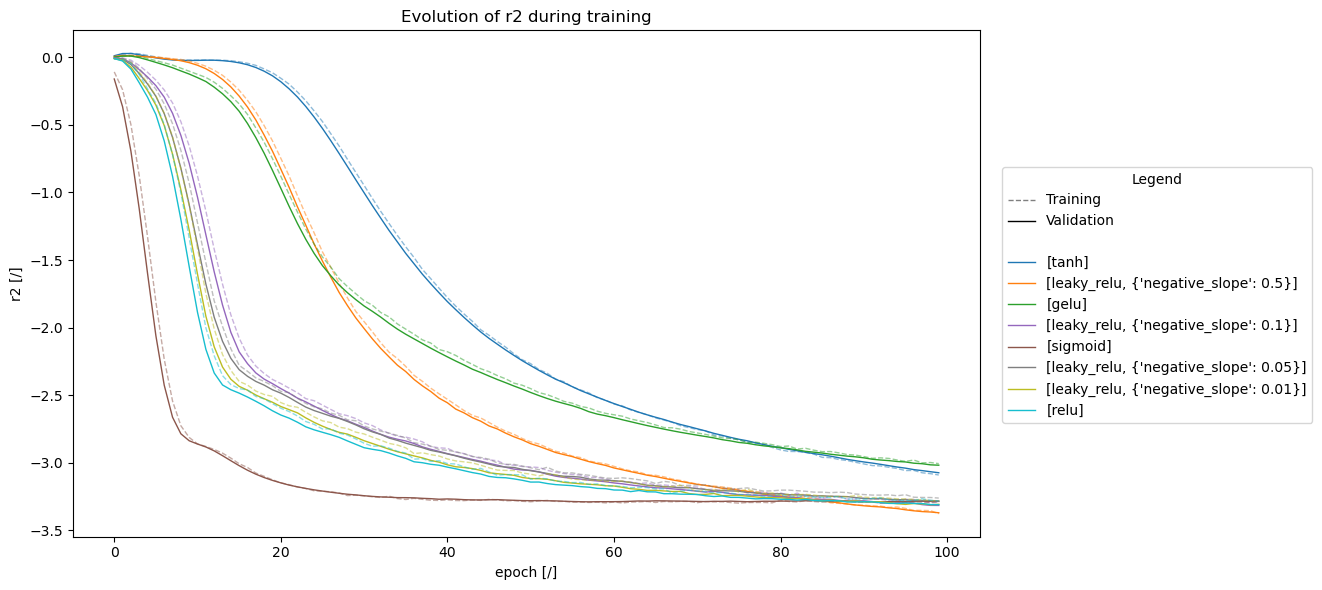

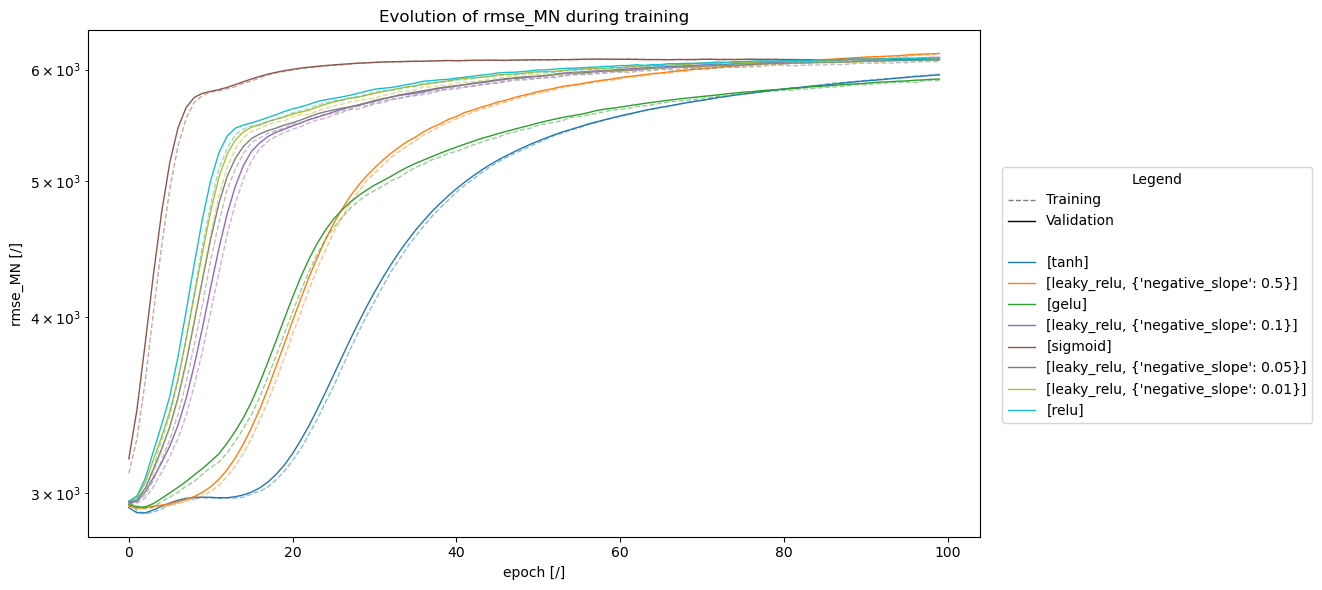

In [39]:
# Your existing code for preparing the data
configs = [x[1] for x in sorted([(np.min(v['val_mape']), k) for k, v in results.items()])]
labels = [f"[{cfg[0]}]" if cfg[1] == 'None' else f"[{cfg[0]}, {cfg[1]}]" for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [40]:
best_activation = 'tanh'
best_activation_params = None

### Learning rate

In [41]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("learning_rate")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 100
lr_values = sorted(np.hstack([f * np.logspace(-4, -3, 2) for f in [1, 2.5, 5, 7.5]]))

log_step = -1

kfold = 10
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for LR in lr_values:
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 29,
                                         'activation': best_activation,
                                         'activation_params': best_activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, StiffnessToLoadLoss, kfold, log_step, {'loss': 'pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run welcoming-fish-538 at: http://127.0.0.1:5005/#/experiments/598157401778491798/runs/99fe2d5e727f4e57a27d6f7db1366900
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/598157401778491798
🏃 View run suave-skink-77 at: http://127.0.0.1:5005/#/experiments/598157401778491798/runs/6eff5c9ee48d4c3a86606fcd673bf4ac
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/598157401778491798
🏃 View run enthused-rook-512 at: http://127.0.0.1:5005/#/experiments/598157401778491798/runs/753c16c7ee7645bc97e54f9513617f7e
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/598157401778491798
🏃 View run hilarious-wasp-843 at: http://127.0.0.1:5005/#/experiments/598157401778491798/runs/463e6e8f3e83432b9c3bbb8aee2e7a41
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/598157401778491798
🏃 View run silent-carp-982 at: http://127.0.0.1:5005/#/experiments/598157401778491798/runs/96322c9599e647129186a8f92d89b64e
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/5981574

In [42]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

learning_rates = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in learning_rates}
for lr in learning_rates:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'pinn') &
        (runs_df['params.learning_rate'] == lr)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

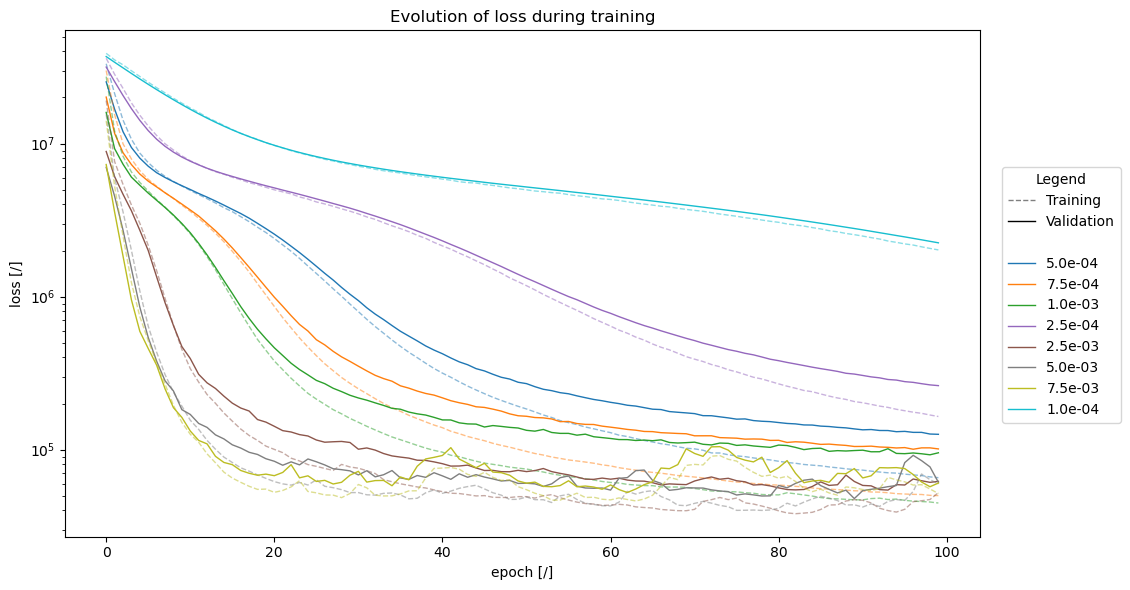

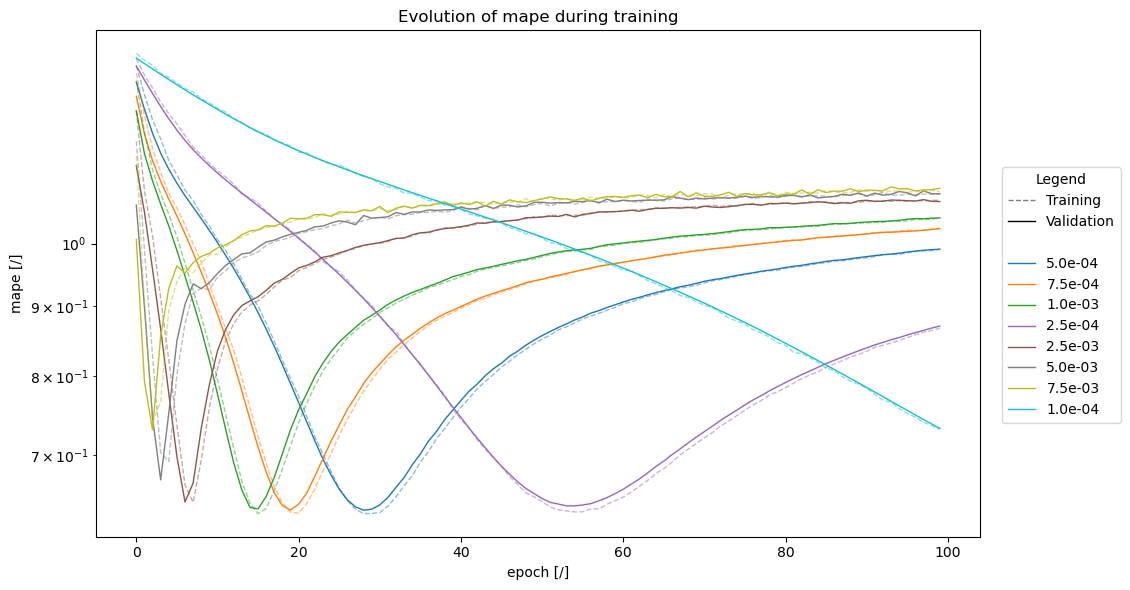

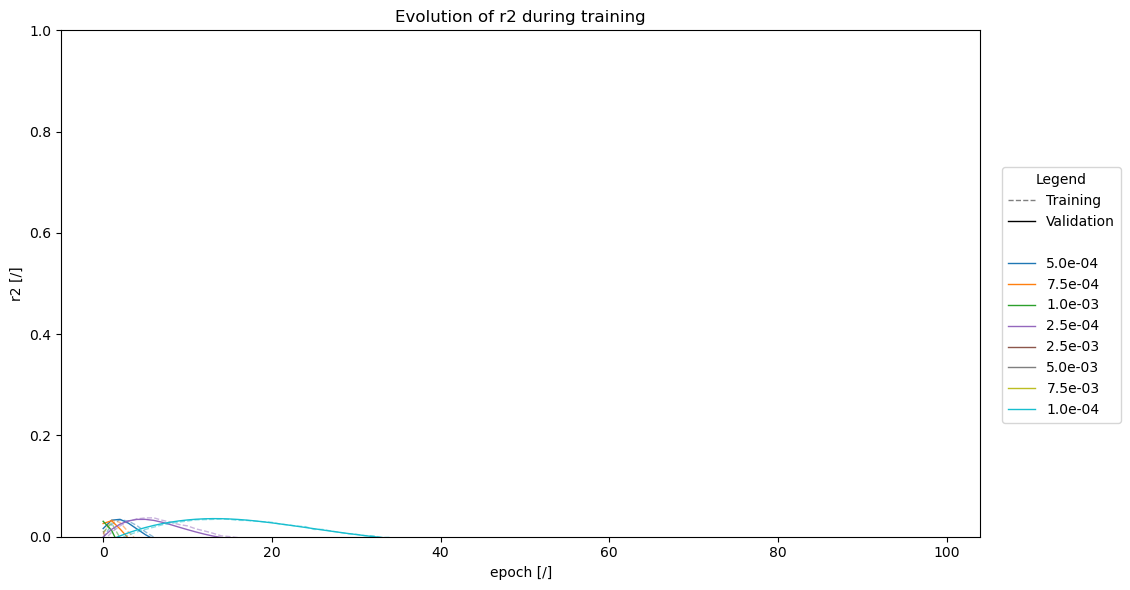

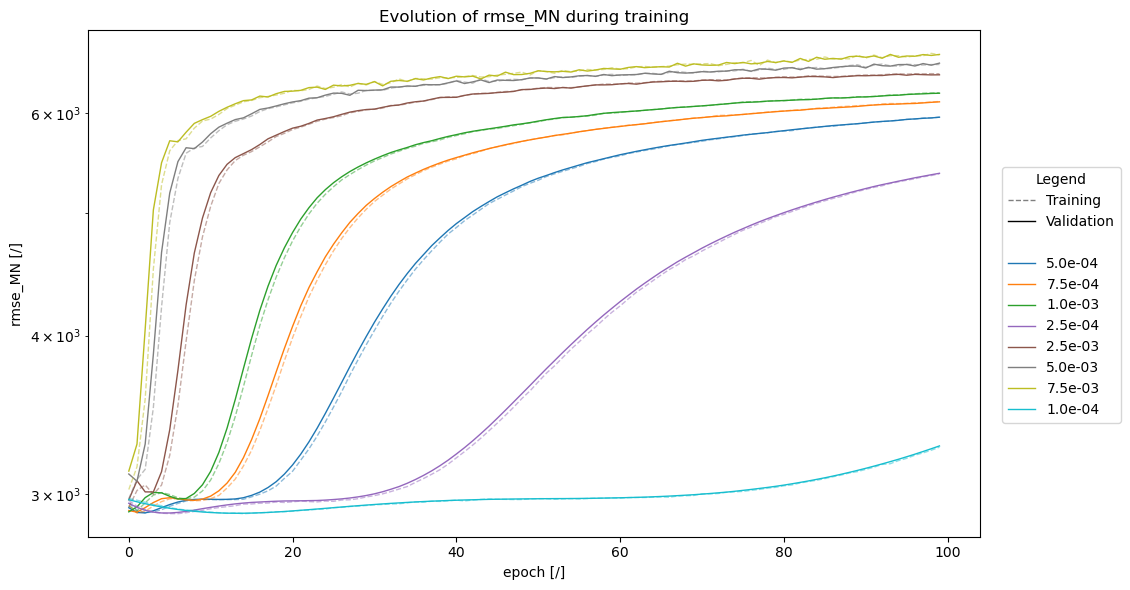

In [43]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{float(c):.1e}" for c in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(0, 1))
plot(results, configs, 'rmse_MN', labels)

In [45]:
best_lr = 5e-4

### Training

In [46]:
best_lr_old = best_lr
best_lr = 5e-4

mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("training")

VAL_BATCH_SIZE = 8192
N_EPOCH = 500
log_step = -1

sizes = [2 ** i for i in range(8, 15)]
batch_size_values = [512 for _ in sizes]  # [int(min(np.power(2, np.floor(np.log2(n)) - 1), 512)) for n in sizes]
dataset_path_values = [f"data/dataset/pratt_truss_bridge/multiple_ea/train_{n}.hdf5" for n in sizes]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
        size = sizes[i]
        train_dataset = FixedPrattTrussDataset(dataset_path)
        validation_dataset = FixedPrattTrussDataset("data/dataset/pratt_truss_bridge/test/all_8192.hdf5")
        future = executor.submit(trial_routine, None, train,
                                 {
                                     'input_dim': 65,
                                     'hidden_dims': best_hidden_dims,
                                     'output_dim': 29,
                                     'activation': best_activation,
                                     'activation_params': best_activation_params,
                                     'dropout': 0.0,
                                     'batch_norm': False,
                                     'layer_norm': False,
                                     'normalization_params': None,
                                     'output_activation': None,
                                     'output_activation_params': None
                                 },
                                 train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                 N_EPOCH,
                                 torch.optim.Adam, best_lr, StiffnessToLoadLoss,
                                 -1, log_step, {'loss': 'pinn', 'noise': 0.})
        futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run welcoming-owl-975 at: http://127.0.0.1:5005/#/experiments/965839871236026849/runs/7a30576e57094af5a4d3c67231ee9312
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/965839871236026849
🏃 View run bustling-shark-754 at: http://127.0.0.1:5005/#/experiments/965839871236026849/runs/944acd86ca0e401d92205ce288269d1b
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/965839871236026849
🏃 View run youthful-worm-339 at: http://127.0.0.1:5005/#/experiments/965839871236026849/runs/df388b665aec468780a6d96b6b711597
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/965839871236026849
🏃 View run redolent-lamb-767 at: http://127.0.0.1:5005/#/experiments/965839871236026849/runs/e5972a6c804a4a1586741983635ba21e
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/965839871236026849
🏃 View run ambitious-donkey-928 at: http://127.0.0.1:5005/#/experiments/965839871236026849/runs/b2c2ced38cad4fa0a3d1a162c0cc756d
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/

In [47]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'pinn') &
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

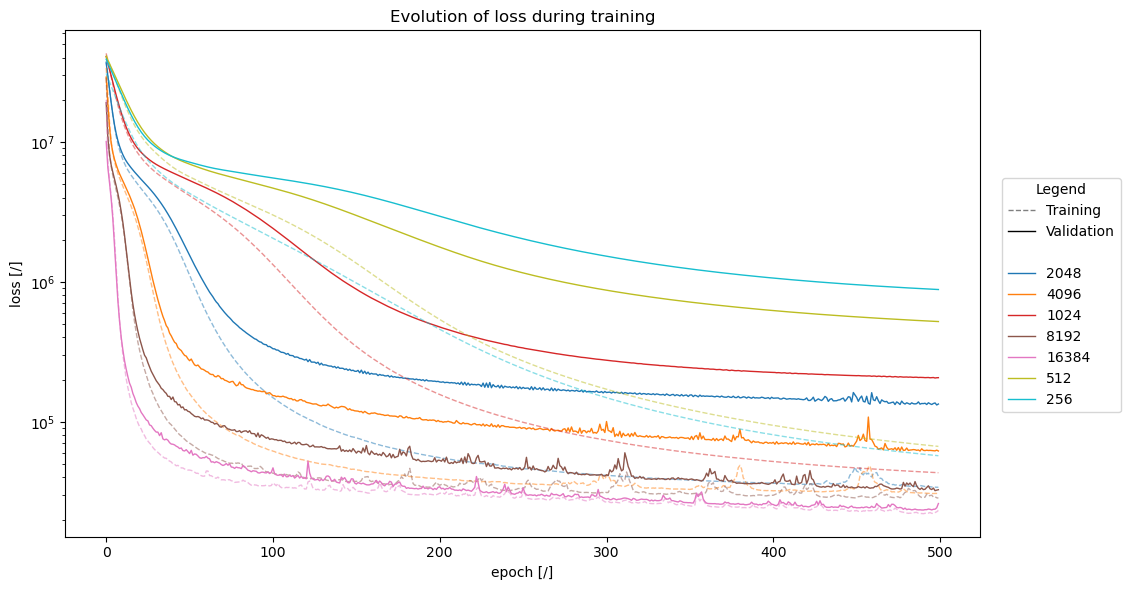

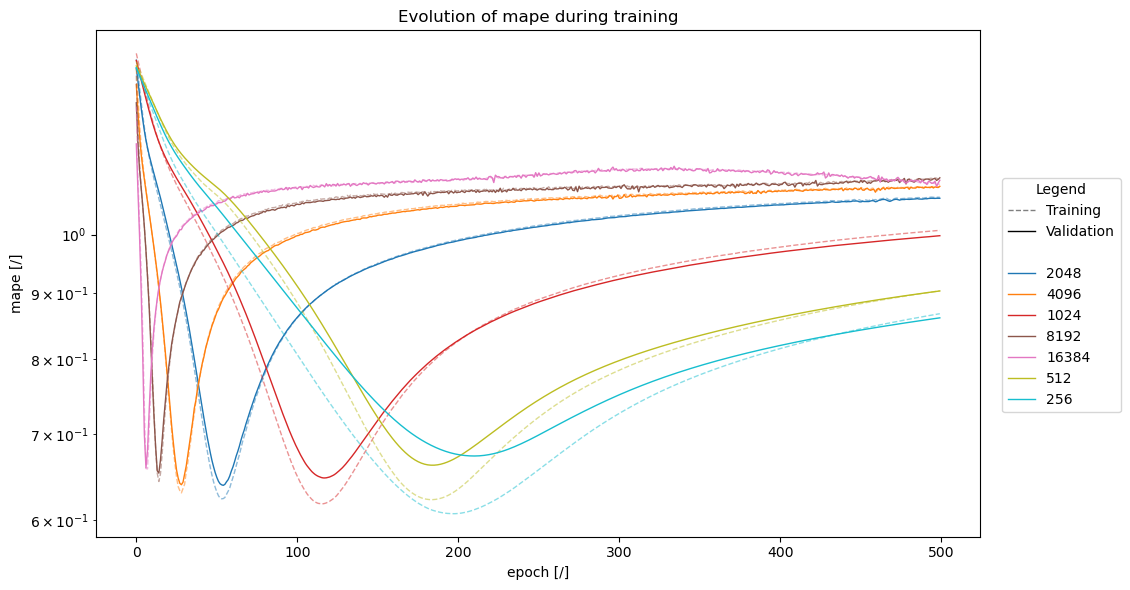

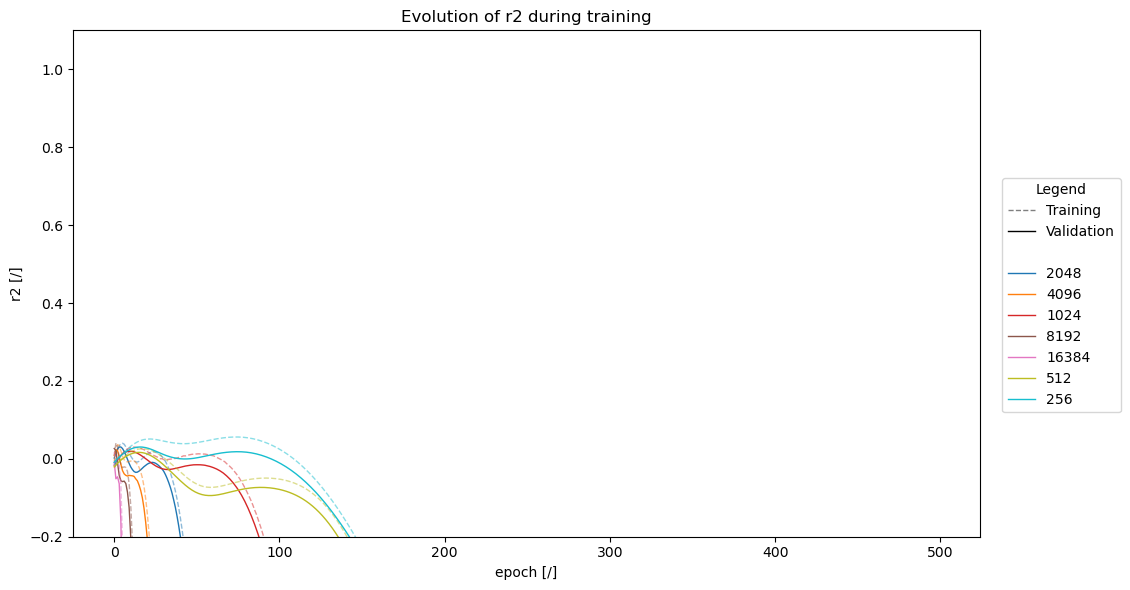

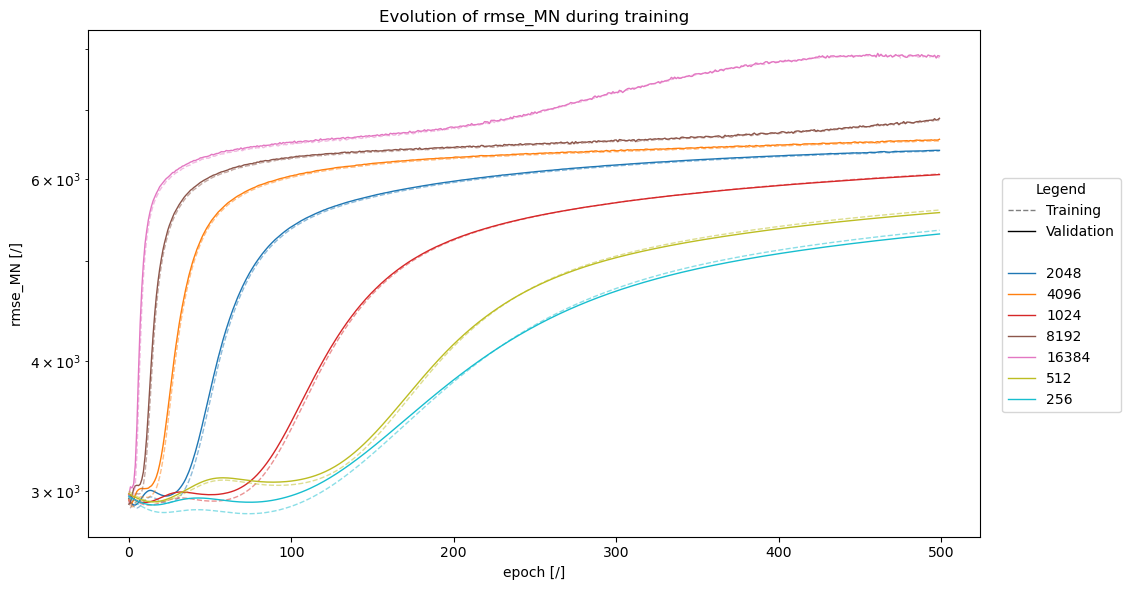

In [48]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{int(size)}" for size in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(-.2, 1.1))
plot(results, configs, 'rmse_MN', labels)

### Noise sensitivity

In [20]:
%%capture

for set_path, set_name in zip(
        ["data/dataset/pratt_truss_bridge/test/single_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/member_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/all_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/mixed_8192.hdf5", ],
        ['single_ea', 'member_ea', 'all_ea', 'mixed_ea']
):
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    experiment = mlflow.get_experiment_by_name("training")
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[runs_df['params.loss'] == 'pinn']
    results = []

    for f in np.linspace(0, .1, 6):
        validation_ds = FixedPrattTrussDataset(
            set_path,
            f_noise_length=None,
            f_noise_loads=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
            f_noise_strain=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
            f_noise_displacement=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
        )

        dl = DataLoader(validation_ds, batch_size=8192)

        for i in range(len(runs_df[['artifact_uri', 'params.train_size']])):
            artifact_uri = runs_df.iloc[i]['artifact_uri']
            size = runs_df.iloc[i]['params.train_size']

            uri = f"{artifact_uri}/input_scaler/"
            input_scaler = load_model(uri)

            uri = f"{artifact_uri}/target_scaler/"
            target_scaler = load_model(uri)

            uri = f"{artifact_uri}/mape_model/"
            model = load_model(uri)

            for batch in dl:
                metrics = validation(model, batch, input_scaler, target_scaler, StiffnessToLoadLoss())
            results.append((size, f, metrics))

    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("noise_sensitivity")

    df = pd.DataFrame([[results[i][0], results[i][1],
                        results[i][2]['r2'].item(),
                        results[i][2]['mape'].item(),
                        results[i][2]['rmse_MN'].item(),
                        results[i][2]['loss']]
                       for i in range(len(results))],
                      columns=['train_size', 'noise', 'r2', 'mape', 'rmse_MN', 'loss'])
    df.sort_values(by=['train_size', 'noise'], axis=0, ignore_index=True, inplace=True)

    for size in df.train_size.unique():
        with mlflow.start_run():
            df_2 = df[df['train_size'] == size]
            # Model information logging
            mlflow.log_params({
                'train_size': size,
                'loss': 'pinn',
                'test_set': set_name
            })
            for i in range(len(df_2)):
                mlflow.log_metrics(
                    dict(df_2.iloc[i][1:]),
                    step=i
                )

# MSE + PINN

In [4]:
def u_from_x(x, n_panels=8):
    batch_size = len(x)
    u = torch.zeros((batch_size, 4 * n_panels), device=x.device)
    u[:, 2:2 * n_panels + 1] = x[:, :2 * (n_panels - 1) + 1]
    u[:, 2 * (n_panels + 1):] = x[:, 2 * (n_panels - 1) + 1:4 * n_panels - 3]
    return u.unsqueeze(-1)


def q_from_x_q(x, q, n_panels=8):
    q = q.squeeze(-1)
    q[:, np.arange(3, 2 * n_panels, 2)] = x[:, 4 * n_panels - 3: 5 * n_panels - 4]

    return q.unsqueeze(-1)


def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion_data, criterion_phys, f_criterion_phys):
    model.train()

    input, target, _, u, q = batch
    input, target = input.to(device), target.to(device)
    u, q = u.to(device), q.to(device)
    q[:, [0, 1, 17], :] = 0.

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    k_pred = pratt_stiffness_matrix(7.5, 7.5, target_pred).to(device)

    optimizer.zero_grad()
    loss_data = criterion_data(z_target_pred, z_target)
    loss_phys = criterion_phys(k_pred * 1e-6,
                               u_from_x(input, 8) * 1e3,
                               q_from_x_q(input, q, 8) * 1e-3)

    loss = loss_data + loss_phys * f_criterion_phys
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss_data'] = loss_data.item()
    metrics['loss_phys'] = loss_phys.item()
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion_data, criterion_phys, f_criterion_phys):
    model.eval()
    with torch.no_grad():
        input, target, _, u, q = batch
        input, target = input.to(device), target.to(device)
        u, q = u.to(device), q.to(device)
        q[:, [0, 1, 17], :] = 0.

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        k_pred = pratt_stiffness_matrix(7.5, 7.5, target_pred).to(device)

        loss_data = criterion_data(z_target_pred, z_target)
        loss_phys = criterion_phys(k_pred * 1e-6,
                                   u_from_x(input, 8) * 1e3,
                                   q_from_x_q(input, q, 8) * 1e-3)
        loss = loss_data + loss_phys * f_criterion_phys

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss_data'] = loss_data.item()
    metrics['loss_phys'] = loss_phys.item()
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss', 'loss_data', "loss_phys"] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss', 'loss_data', "loss_phys"] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer,
          criterion_data, criterion_phys, f_criterion_phys, log_step=10):
    model = model.to(device)
    criterion_phys = criterion_phys.to(device)
    criterion_data = criterion_data.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'loss_phys': {model: None, 'value': np.inf, 'epoch': -1},
        'loss_data': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer,
                                             criterion_data, criterion_phys, f_criterion_phys)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler,
                                           criterion_data, criterion_phys, f_criterion_phys)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion_data, criterion_phys, f_criterion_phys,
                  fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': f"{lr:.1e}",
            'criterion_data': criterion_data.__name__,
            'criterion_phys': criterion_phys.__name__,
            'pinn_factor': f_criterion_phys
        })

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr),
                      criterion_data(), criterion_phys(), f_criterion_phys,
                      log_step=log_step)

In [5]:
def plot(results, configs, metric, labels, log=True, xlim=None, ylim=None):
    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, len(configs)))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data but collect the handles for the legend
    config_handles = []
    for i, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])
        h = ax.plot(np.arange(l), results[conf][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
        h2 = ax.plot(np.arange(l), results[conf][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
        config_handles.append(h2)

    # Create custom handles for the line style legend
    line_style_handles = [
        Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
        Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
        Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
    ]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    all_handles = line_style_handles + config_handles
    all_labels = ['Training', 'Validation', ''] + labels

    # Create a single legend with both line styles and configurations
    plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
                  title="Legend")

    ax.set_title(f"Evolution of {metric} during training")
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{metric} [/]")
    ax.set_xlabel("epoch [/]")

    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)

    plt.tight_layout()
    # Adjust right padding to make room for the legend
    plt.show()

## Hyperparameter tuning

## Loss factor

In [7]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("pinn_loss_factor")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

factor_values = np.logspace(-9, -3, 7)
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for f_pinn in factor_values:
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': [120 for _ in range(5)],
                                         'output_dim': 29,
                                         'activation': "relu",
                                         'activation_params': None,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, f_pinn,
                                     kfold, log_step, {'loss': 'mse + pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run unleashed-flea-462 at: http://127.0.0.1:5011/#/experiments/209344094118667275/runs/9b94ea2f2a004998908ac1c013c9c1bc
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/209344094118667275
🏃 View run marvelous-hen-803 at: http://127.0.0.1:5011/#/experiments/209344094118667275/runs/823384ea37914dc19e77e4f456d301f9
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/209344094118667275
🏃 View run funny-mule-848 at: http://127.0.0.1:5011/#/experiments/209344094118667275/runs/b6ae451e7dc34e8c9c4270e5cf44833b
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/209344094118667275
🏃 View run inquisitive-croc-202 at: http://127.0.0.1:5011/#/experiments/209344094118667275/runs/aa0c888f6c2c4228b687265e7d27feb6
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/209344094118667275
🏃 View run gifted-sponge-896 at: http://127.0.0.1:5011/#/experiments/209344094118667275/runs/fa8e54563bee4686a09519b33a223b92
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/209

In [8]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("pinn_loss_factor")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

pinn_factors = set(runs_df['params.pinn_factor'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in pinn_factors}
for f in pinn_factors:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.pinn_factor'] == f)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[f][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

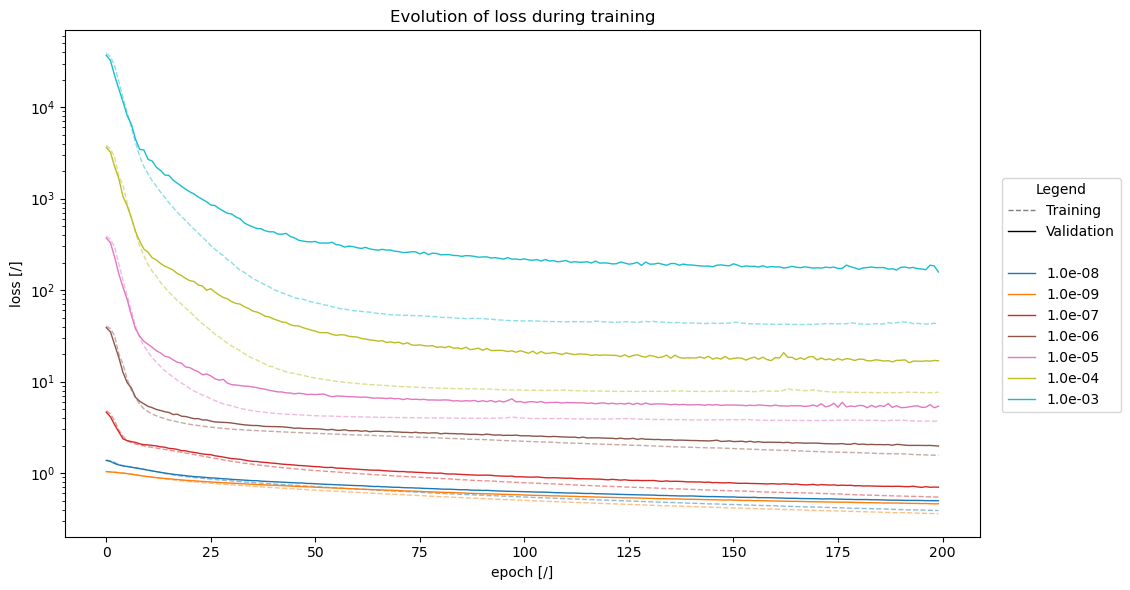

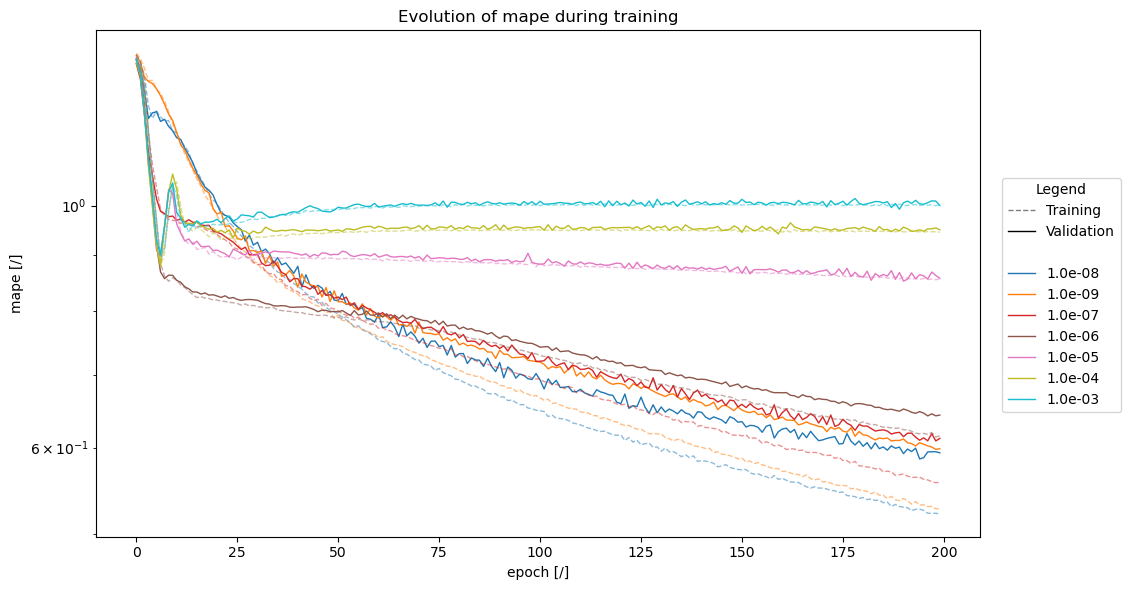

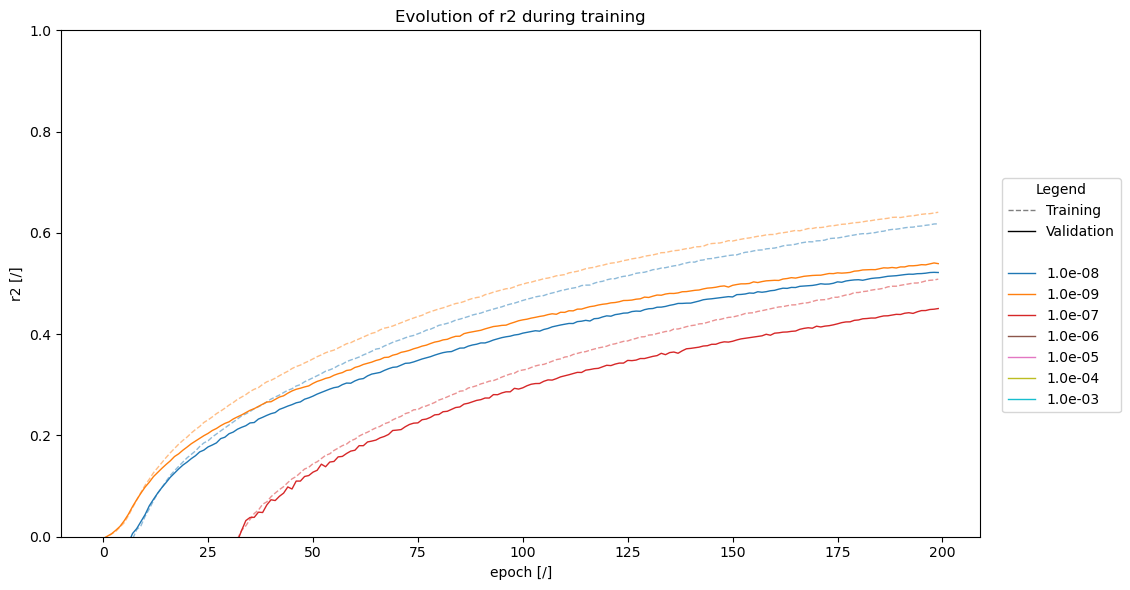

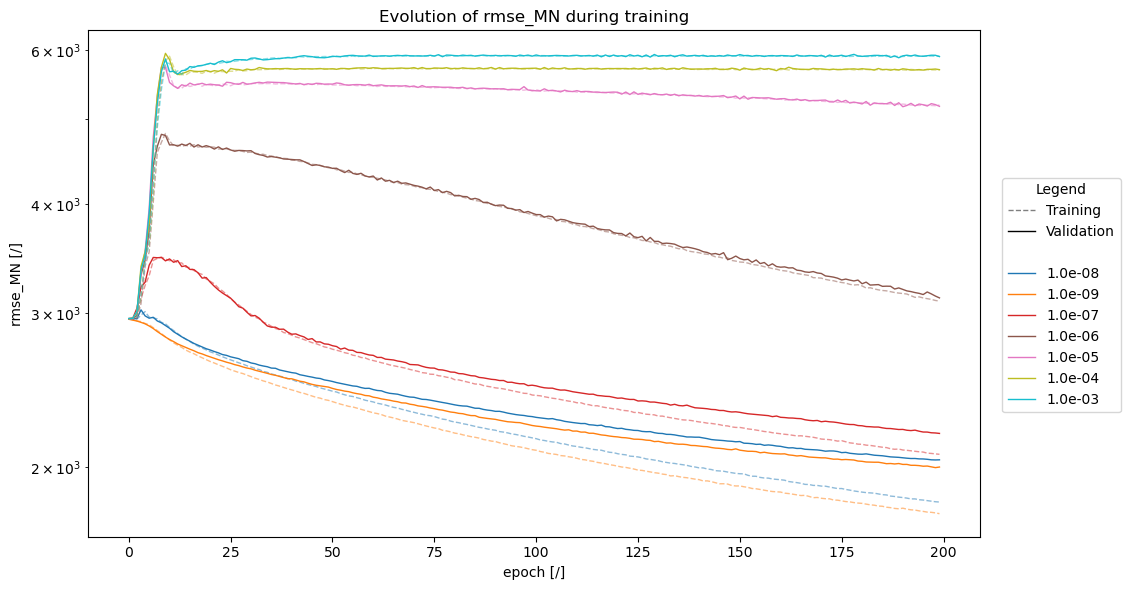

In [9]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{float(c):.1e}" for c in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(0, 1))
plot(results, configs, 'rmse_MN', labels)

In [6]:
best_f_pinn = 1e-8

### Model capacity

In [ ]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("model_capacity")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

n_layers_values = [2, 3, 4, 5]
n_neurons_values = [65, 70, 80, 80, 100, 120]
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for n_layers in n_layers_values:
        for n_neurons in n_neurons_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                hidden_dims = [n_neurons for _ in range(n_layers)]
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': hidden_dims,
                                             'output_dim': 29,
                                             'activation': "relu",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None,
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, best_f_pinn,
                                         kfold, log_step, {'loss': 'mse + pinn'})
                futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run puzzled-dolphin-664 at: http://127.0.0.1:5011/#/experiments/580542739104971203/runs/e3f08d5bf909465dae1510e1ed400085
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/580542739104971203
🏃 View run upset-swan-909 at: http://127.0.0.1:5011/#/experiments/580542739104971203/runs/d3166f631ab24f2ca98819e7b8b11706
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/580542739104971203
🏃 View run efficient-cow-409 at: http://127.0.0.1:5011/#/experiments/580542739104971203/runs/90af85888c2e44a1bff087d4a722cf65
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/580542739104971203
🏃 View run merciful-hen-691 at: http://127.0.0.1:5011/#/experiments/580542739104971203/runs/520ebe997e2348eea8f444d809c63af3
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/580542739104971203
🏃 View run thundering-zebra-380 at: http://127.0.0.1:5011/#/experiments/580542739104971203/runs/1201c1b386a24f218727172c05eab830
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/580

In [13]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("model_capacity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'mse + pinn']

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

layers_combinations = set()
for n_layers in runs_df['params.n_hidden_layers'].unique():
    for layer_size in runs_df['params.hidden_layers_size'].unique():
        layers_combinations.add((n_layers, layer_size))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in layers_combinations}
for n, size in layers_combinations:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.n_hidden_layers'] == n) &
        (runs_df['params.hidden_layers_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(n, size)][metric_name].append(
                [metric.value for metric in client.get_metric_history(run_id, metric_name)])

keys = list(results.keys())
for k in keys:
    vi = results[k].values().__iter__().__next__()
    if len(vi) == 0: del results[k]

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

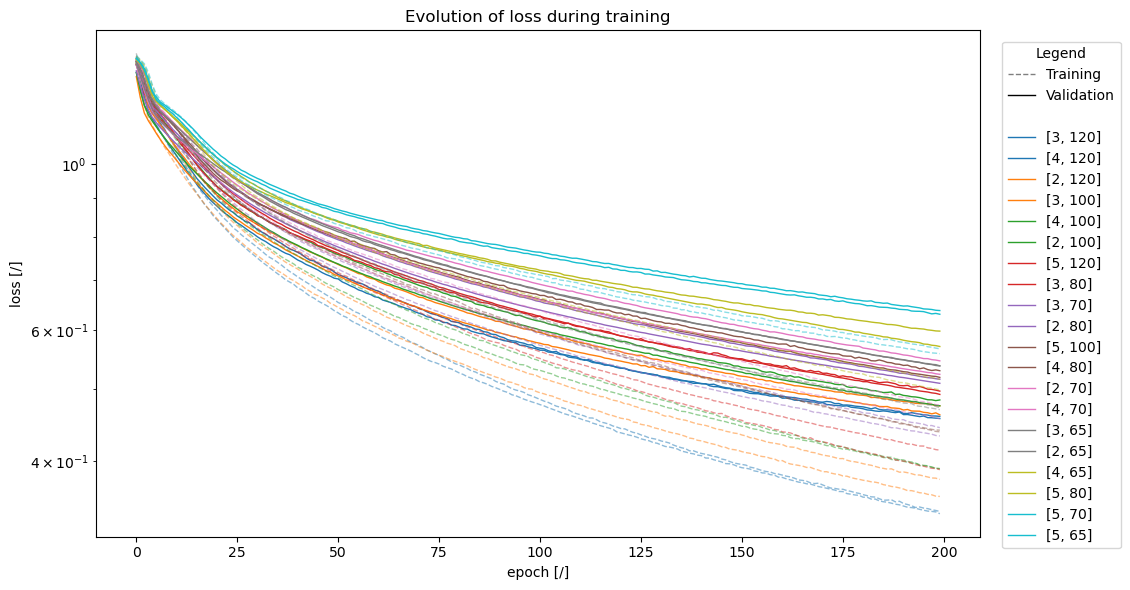

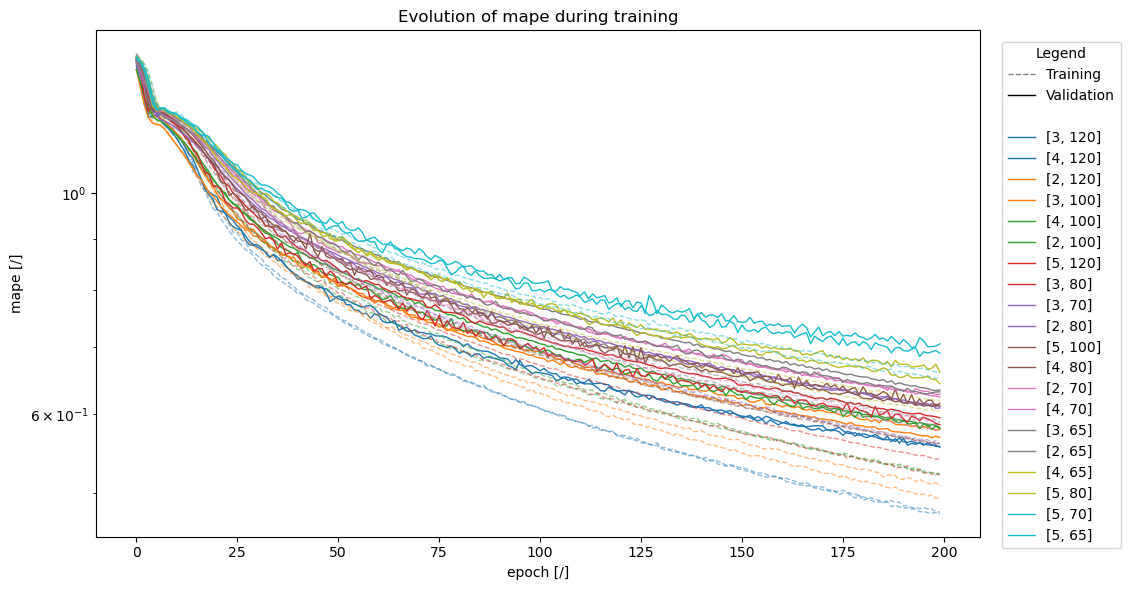

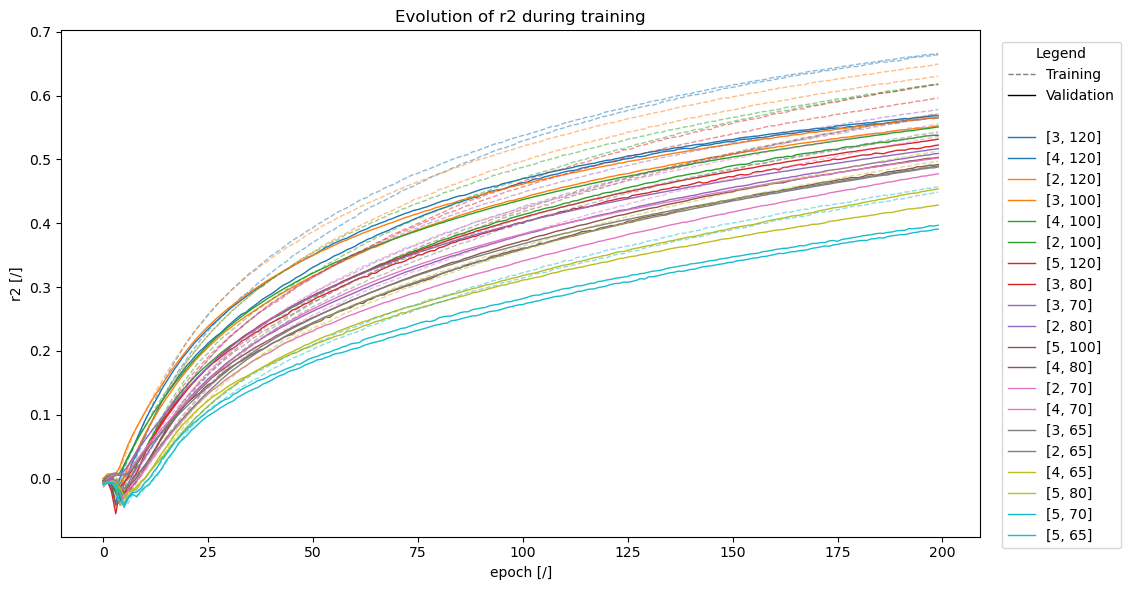

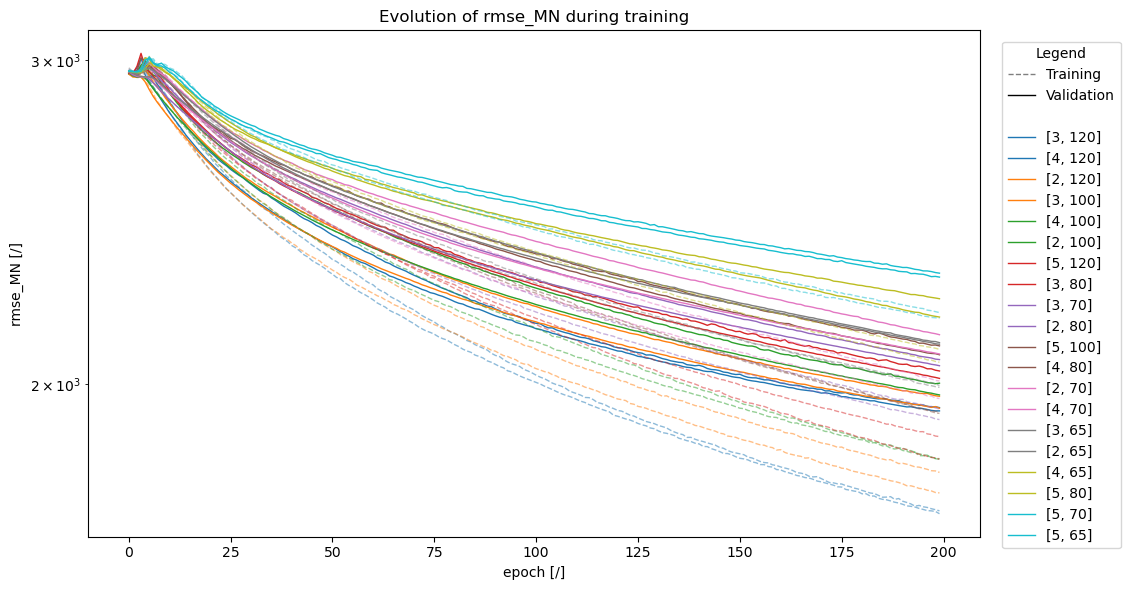

In [14]:
# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs]

labels = [str([int(x) for x in cfg]) for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [7]:
best_hidden_dims = [3 for _ in range(120)]

### Activation function

In [17]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("activation_function")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

activation_values = ['relu', 'gelu', 'tanh', 'sigmoid',
                     'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']
activation_params_values = [None, None, None, None,
                            {'negative_slope': 5e-1}, {'negative_slope': 1e-1}, {'negative_slope': 5e-2},
                            {'negative_slope': 1e-2}]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for activation, activation_params in zip(activation_values, activation_params_values):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 29,
                                         'activation': activation,
                                         'activation_params': activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, best_f_pinn,
                                     kfold, log_step, {'loss': 'mse + pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run skillful-bird-319 at: http://127.0.0.1:5011/#/experiments/427931552705032902/runs/dfd2965bb0a54b4290505ddbbf971b26
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/427931552705032902
🏃 View run nosy-croc-611 at: http://127.0.0.1:5011/#/experiments/427931552705032902/runs/8622a2d37f38420e992abfd5b818b1ca
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/427931552705032902
🏃 View run amazing-penguin-47 at: http://127.0.0.1:5011/#/experiments/427931552705032902/runs/fe8870d95c0848c4a28aca1c56c01dc8
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/427931552705032902
🏃 View run respected-dolphin-30 at: http://127.0.0.1:5011/#/experiments/427931552705032902/runs/d5e295cc38b9401a9a930a151b75bca3
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/427931552705032902
🏃 View run industrious-crab-909 at: http://127.0.0.1:5011/#/experiments/427931552705032902/runs/5292eaa23e224d549c9a9e978b66ad6d
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/4

In [20]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'mse + pinn']

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

activations_combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        activations_combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in activations_combinations}
for k in activations_combinations:
    (act, params) = k
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.activation'] == act) &
        (runs_df['params.activation_params'] == params)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

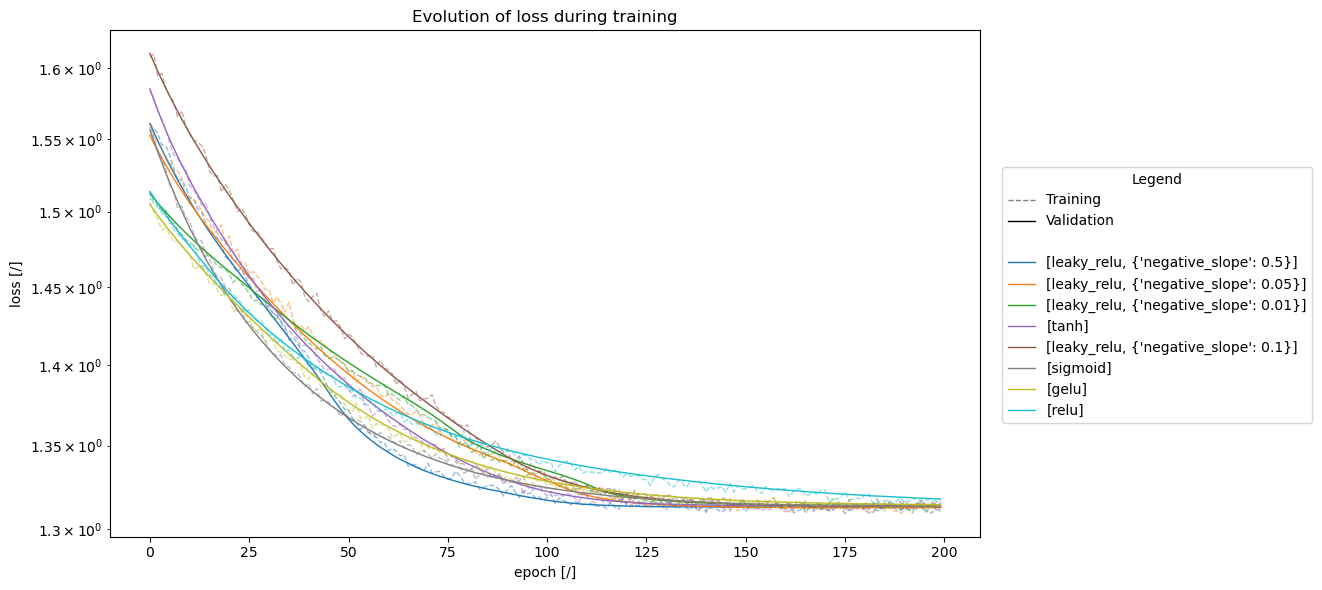

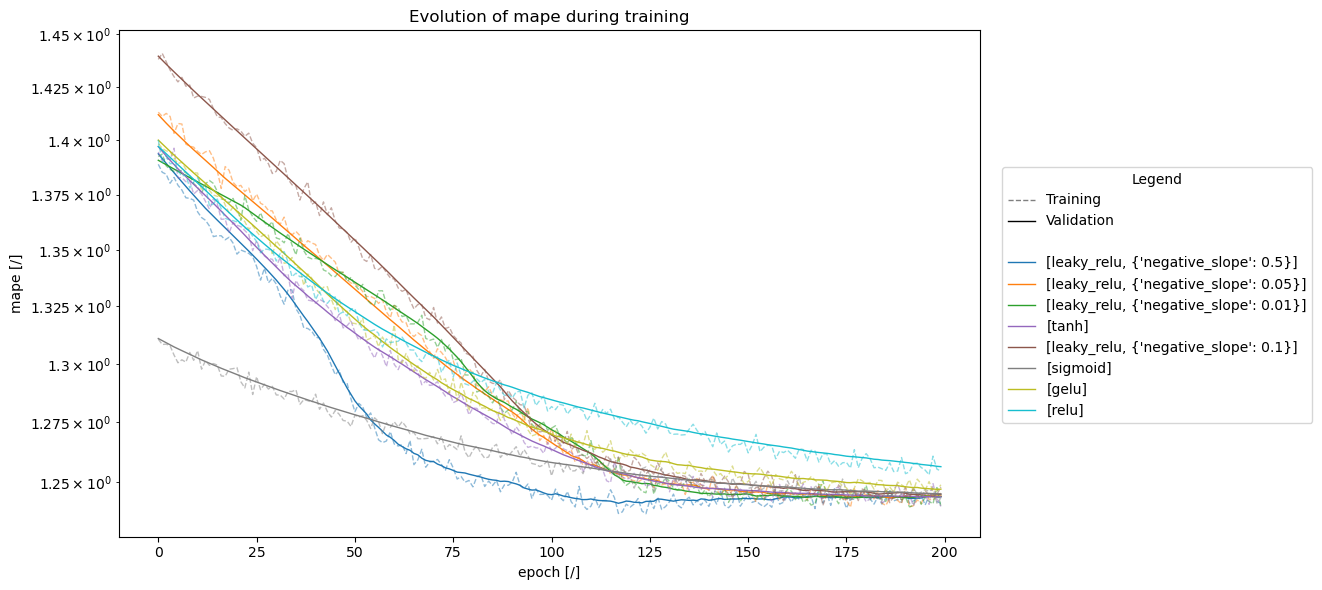

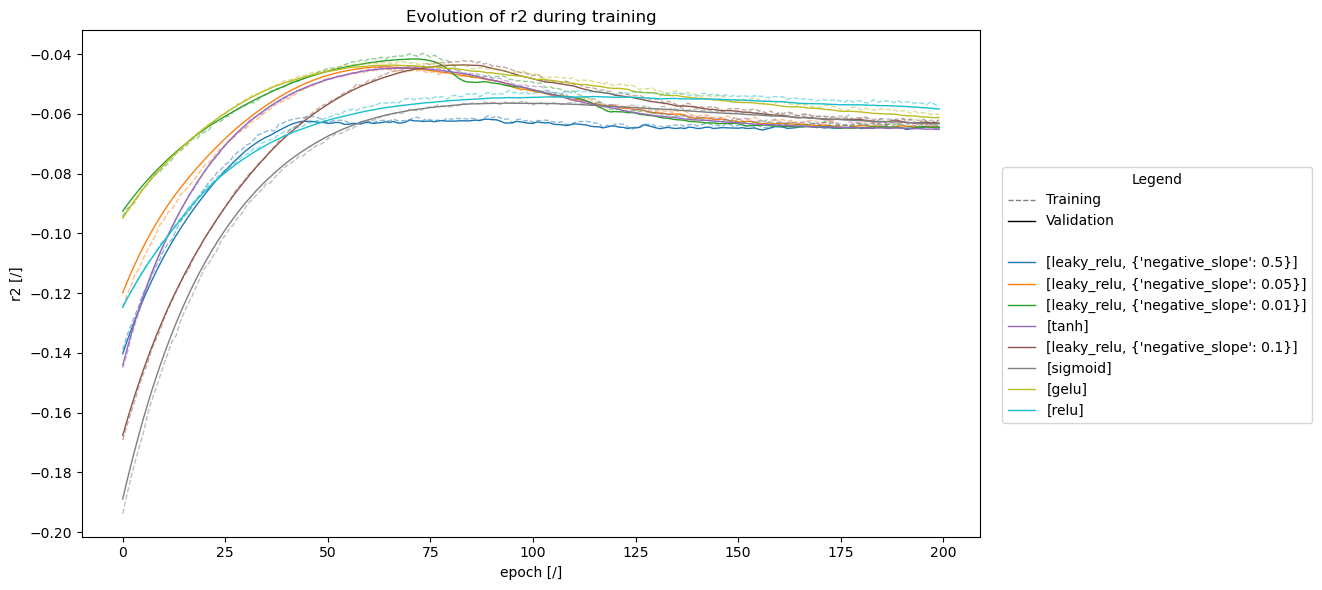

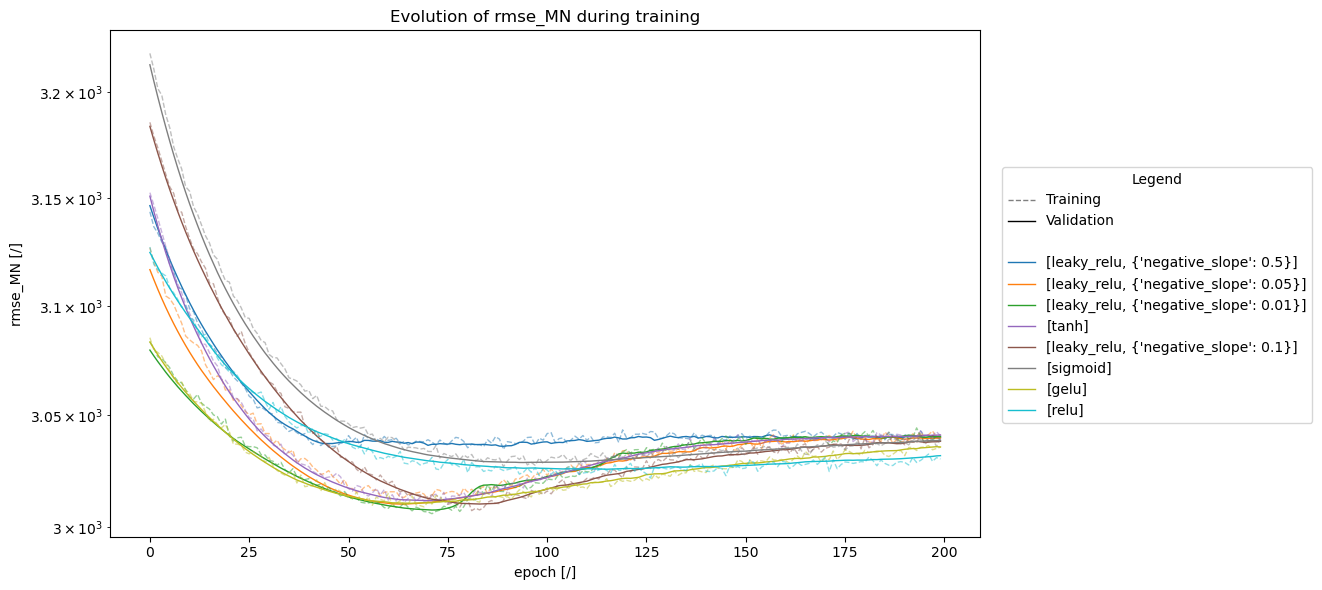

In [21]:
# Your existing code for preparing the data
configs = [x[1] for x in sorted([(np.min(v['val_mape']), k) for k, v in results.items()])]
labels = [f"[{cfg[0]}]" if cfg[1] == 'None' else f"[{cfg[0]}, {cfg[1]}]" for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [8]:
best_activation = 'leaky_relu'
best_activation_params = {'negative_slope': 1e-2}

### Learning rate

In [23]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("learning_rate")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 100
LR = 5e-4

lr_values = sorted(np.hstack([f * np.logspace(-5, -3, 3) for f in [1, 5]]))

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/multiple_ea/train_4096.hdf5"
ds = FixedPrattTrussDataset(dataset_path)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for LR in lr_values:
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 29,
                                         'activation': best_activation,
                                         'activation_params': best_activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, best_f_pinn,
                                     kfold, log_step, {'loss': 'mse + pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run adventurous-skink-26 at: http://127.0.0.1:5011/#/experiments/598157401778491798/runs/d06483056b1d439ba1f9c8c3d8eda192
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/598157401778491798
🏃 View run capricious-mink-924 at: http://127.0.0.1:5011/#/experiments/598157401778491798/runs/579f1ecf187e4b03b0efb0b11d86e02c
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/598157401778491798
🏃 View run learned-cub-290 at: http://127.0.0.1:5011/#/experiments/598157401778491798/runs/34acdc949a544e3093ffa84dff63e5b3
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/598157401778491798
🏃 View run zealous-sow-746 at: http://127.0.0.1:5011/#/experiments/598157401778491798/runs/f797dceb073c4052abb94b553b1d8029
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/598157401778491798
🏃 View run omniscient-wolf-197 at: http://127.0.0.1:5011/#/experiments/598157401778491798/runs/ed61340abb05495093efbc0ad1f48108
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/5

In [25]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'mse + pinn']

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

learning_rates = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in learning_rates}
for lr in learning_rates:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.learning_rate'] == lr)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

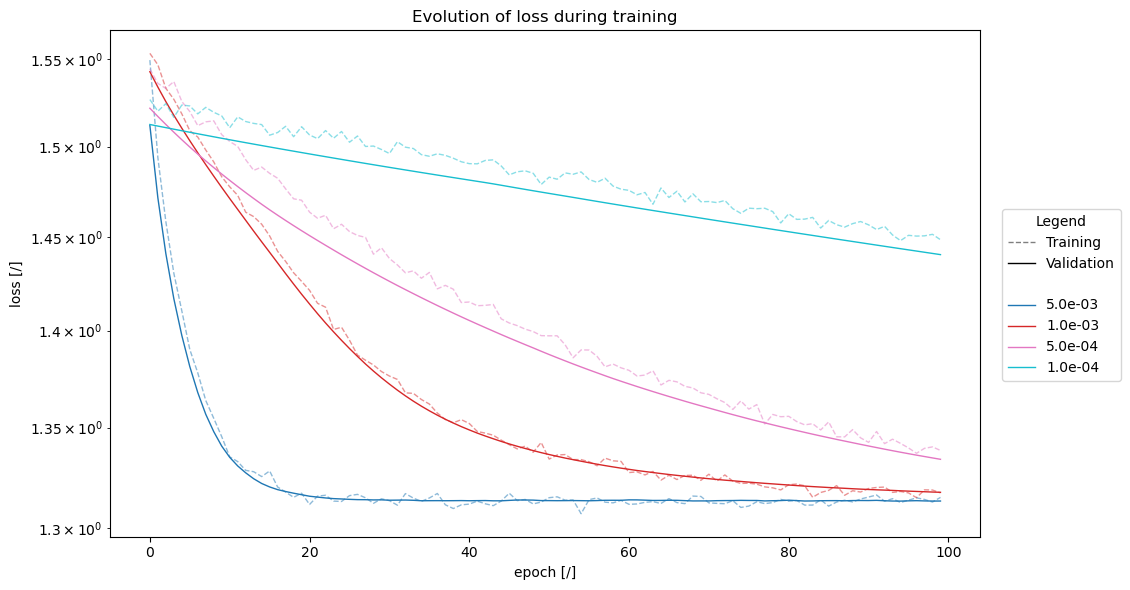

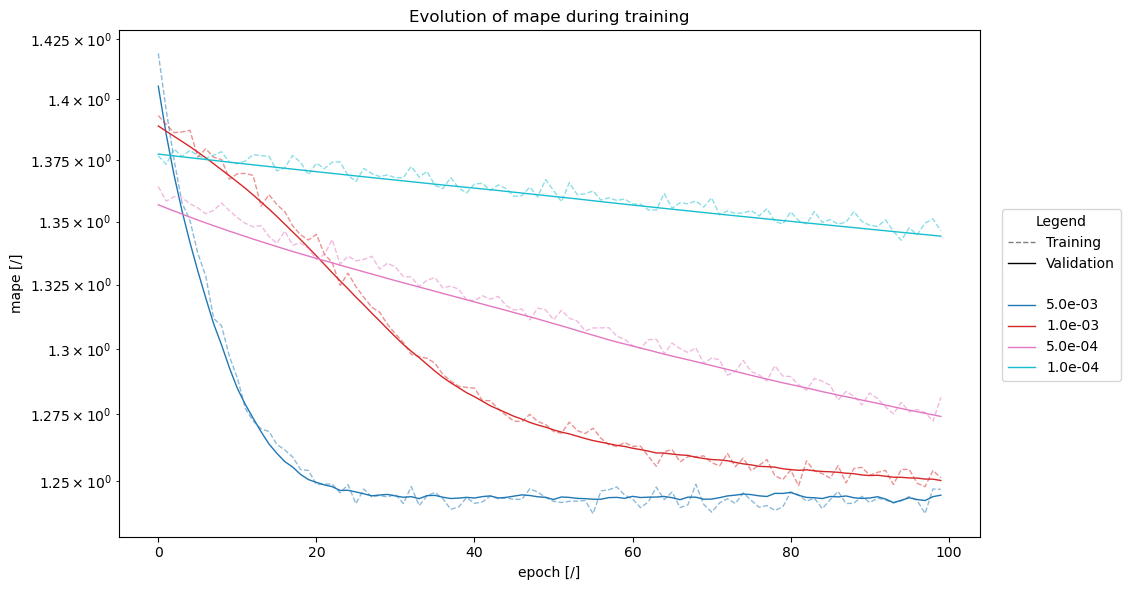

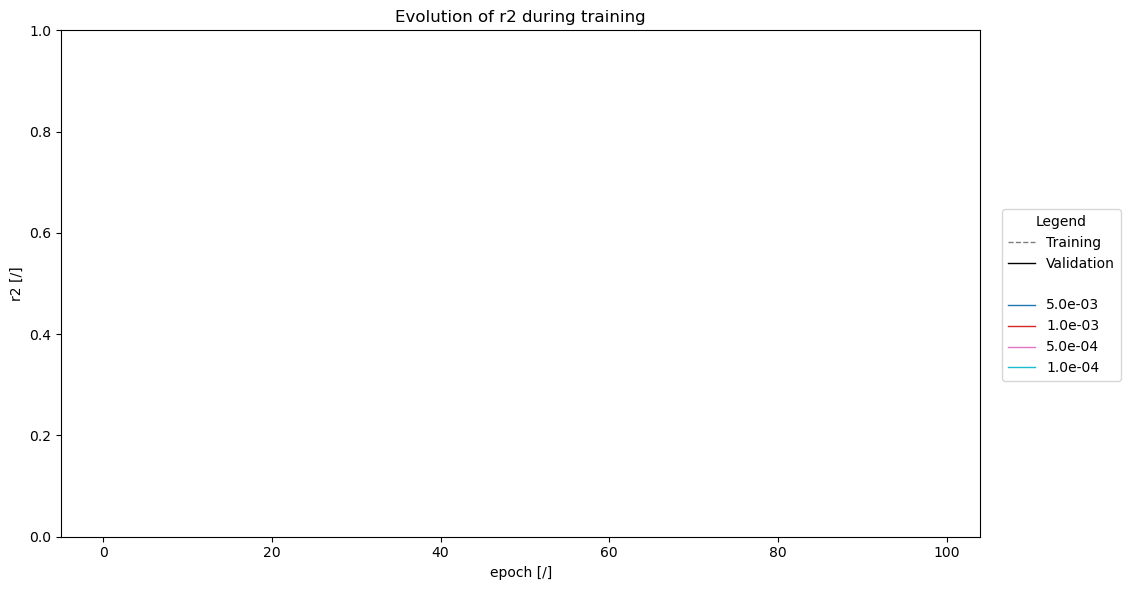

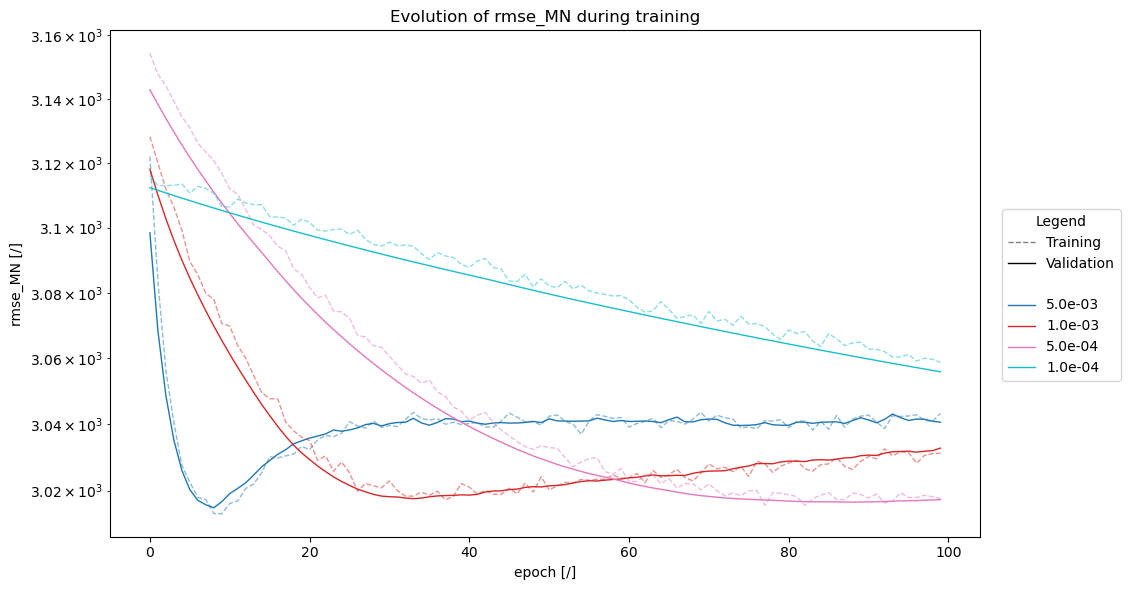

In [26]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs][:4]

"""configs = [
 '7.5e-04',
 '5.0e-04',
 '2.5e-04',
 '1.0e-04',]
"""
labels = [f"{float(c):.1e}" for c in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(0, 1))
plot(results, configs, 'rmse_MN', labels)

In [9]:
best_lr = 1e-3

### Training

In [10]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("training")

VAL_BATCH_SIZE = 8192
N_EPOCH = 1_000
log_step = -1

sizes = [2 ** i for i in range(8, 15)]
batch_size_values = [512 for _ in sizes]  # [int(min(np.power(2, np.floor(np.log2(n)) - 1), 512)) for n in sizes]
dataset_path_values = [f"data/dataset/pratt_truss_bridge/multiple_ea/train_{n}.hdf5" for n in sizes]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
        size = sizes[i]
        train_dataset = FixedPrattTrussDataset(dataset_path)
        validation_dataset = FixedPrattTrussDataset("data/dataset/pratt_truss_bridge/test/all_8192.hdf5")
        future = executor.submit(trial_routine, None, train,
                                 {
                                     'input_dim': 65,
                                     'hidden_dims': best_hidden_dims,
                                     'output_dim': 29,
                                     'activation': best_activation,
                                     'activation_params': best_activation_params,
                                     'dropout': 0.0,
                                     'batch_norm': False,
                                     'layer_norm': False,
                                     'normalization_params': None,
                                     'output_activation': None,
                                     'output_activation_params': None
                                 },
                                 train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                 N_EPOCH,
                                 torch.optim.Adam, best_lr, nn.MSELoss, StiffnessToLoadLoss, best_f_pinn,
                                 -1, log_step, {'loss': 'mse + pinn', 'noise': 0.})
        futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run overjoyed-newt-570 at: http://127.0.0.1:5011/#/experiments/965839871236026849/runs/a32f16270f6243f799a3b2292e77c268
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/965839871236026849
🏃 View run capricious-squid-796 at: http://127.0.0.1:5011/#/experiments/965839871236026849/runs/5327f38ae22b48a89c1dbd0e7bca3ae5
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/965839871236026849
🏃 View run traveling-gull-417 at: http://127.0.0.1:5011/#/experiments/965839871236026849/runs/156140a855cc4c79bf0171e4a36b3897
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/965839871236026849
🏃 View run lyrical-crane-736 at: http://127.0.0.1:5011/#/experiments/965839871236026849/runs/3a2acd0bba2446fd96f60a61ebe11d29
🧪 View experiment at: http://127.0.0.1:5011/#/experiments/965839871236026849
🏃 View run ambitious-ape-646 at: http://127.0.0.1:5011/#/experiments/965839871236026849/runs/214bb56a802041779904cc9d44030caa
🧪 View experiment at: http://127.0.0.1:5011/#/experiments

In [15]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])


cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

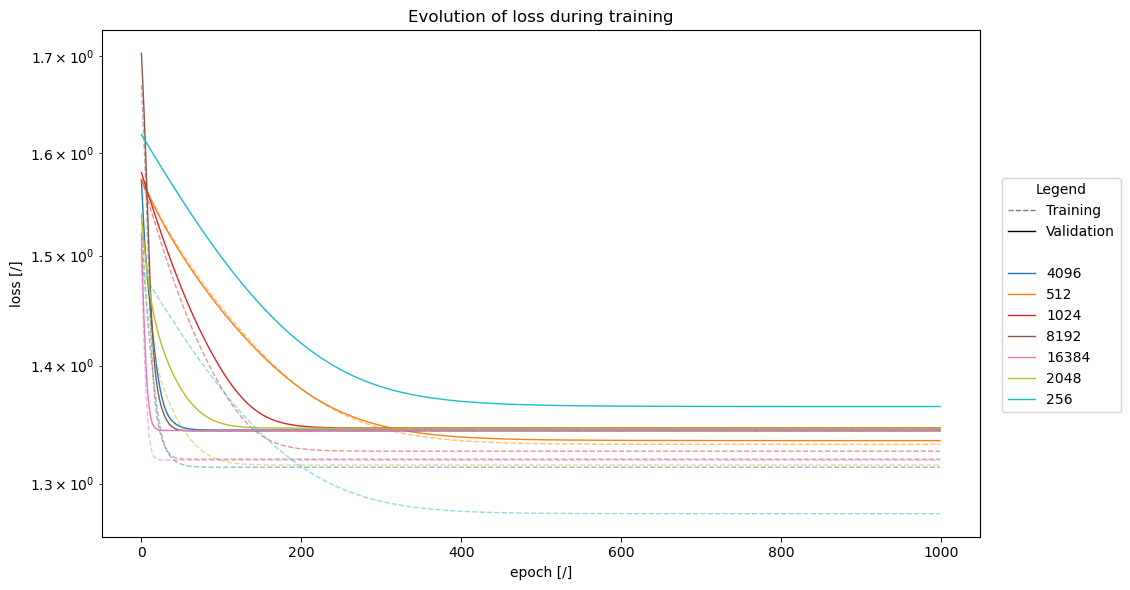

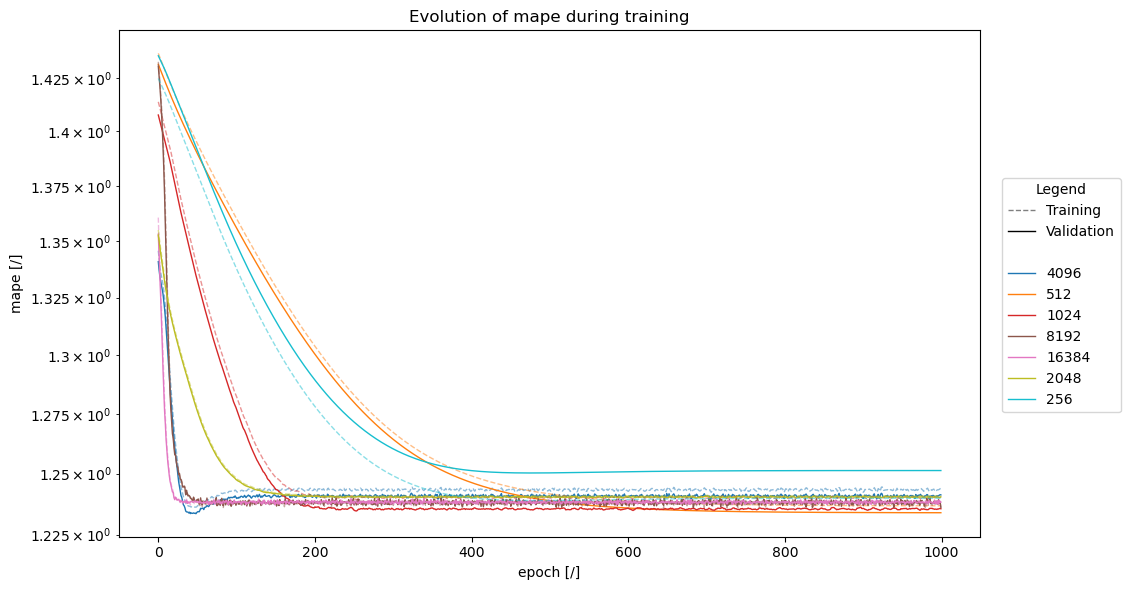

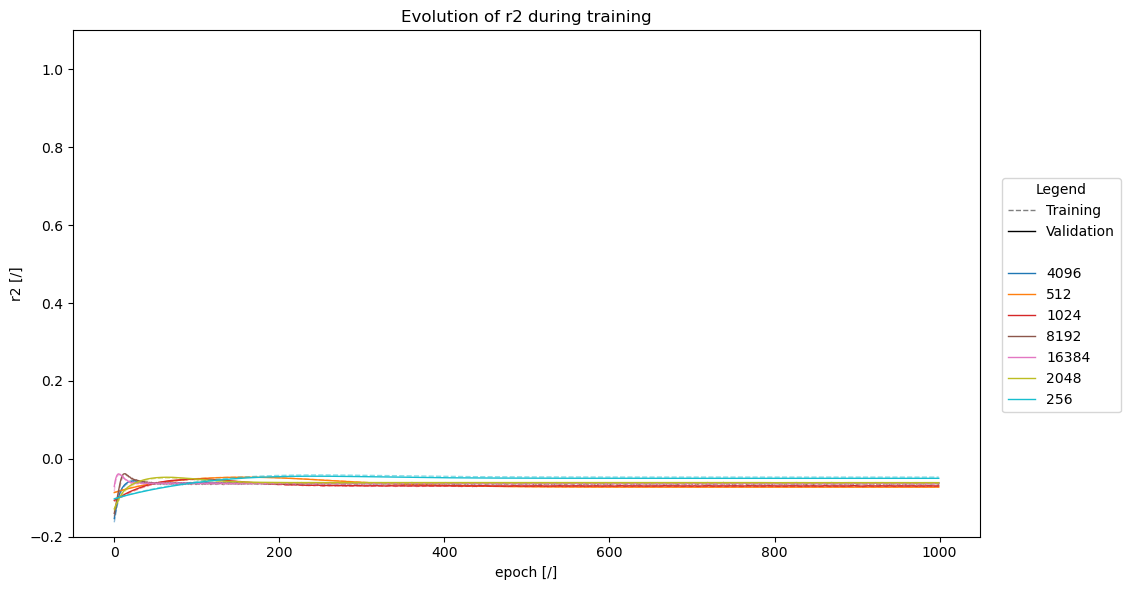

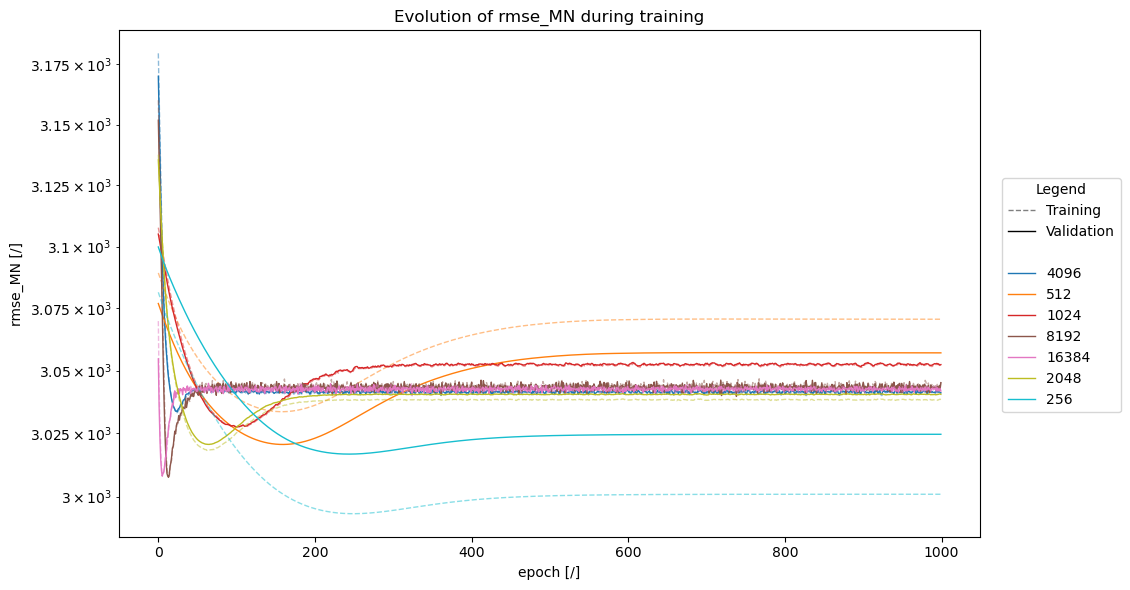

In [16]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{int(size)}" for size in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(-.2, 1.1))
plot(results, configs, 'rmse_MN', labels)

### Noise sensitivity

In [18]:
%%capture
for set_path, set_name in zip(
        ["data/dataset/pratt_truss_bridge/test/single_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/member_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/all_8192.hdf5",
         "data/dataset/pratt_truss_bridge/test/mixed_8192.hdf5", ],
        ['single_ea', 'member_ea', 'all_ea', 'mixed_ea']
):
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    experiment = mlflow.get_experiment_by_name("training")
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[runs_df['params.loss'] == 'mse + pinn']

    results = []

    for f in np.linspace(0, .1, 6):
        validation_ds = FixedPrattTrussDataset(
            set_path,
            f_noise_length=None,
            f_noise_loads=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
            f_noise_strain=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
            f_noise_displacement=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                    (np.random.binomial(1, .5, size=size) * 2.) - 1),
        )

        dl = DataLoader(validation_ds, batch_size=8192)

        for i in range(len(runs_df[['artifact_uri', 'params.train_size']])):
            artifact_uri = runs_df.iloc[i]['artifact_uri']
            size = runs_df.iloc[i]['params.train_size']

            uri = f"{artifact_uri}/input_scaler/"
            input_scaler = load_model(uri)

            uri = f"{artifact_uri}/target_scaler/"
            target_scaler = load_model(uri)

            uri = f"{artifact_uri}/mape_model/"
            model = load_model(uri)

            for batch in dl:
                metrics = validation(model, batch, input_scaler, target_scaler, F.mse_loss, StiffnessToLoadLoss(), best_f_pinn)
            results.append((size, f, metrics))

    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("noise_sensitivity")

    df = pd.DataFrame([[results[i][0], results[i][1],
                        results[i][2]['r2'].item(),
                        results[i][2]['mape'].item(),
                        results[i][2]['rmse_MN'].item(),
                        results[i][2]['loss']]
                       for i in range(len(results))], columns=['train_size', 'noise', 'r2', 'mape', 'rmse_MN', 'loss'])
    df.sort_values(by=['train_size', 'noise'], axis=0, ignore_index=True, inplace=True)

    for size in df.train_size.unique():
        with mlflow.start_run():
            df_2 = df[df['train_size'] == size]
            # Model information logging
            mlflow.log_params({
                'train_size': size,
                'loss': 'mse + pinn',
                'test_set': set_name
            })
            for i in range(len(df_2)):
                mlflow.log_metrics(
                    dict(df_2.iloc[i][1:]),
                    step=i
                )